In [1]:
import sys
import os
import polars as pl
import pandas as pd
import itables

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, "../../", 'src'))

from config import Constants
from preprocessing.preprocessing import BigDataBowlData
from plotting.plotting import PlotPlayVertical
import seaborn as sns

# init_notebook_mode(all_interactive=True)
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(100)


GAMES_FILE = "../../data/games.csv"
PLAYS_FILE = "../../data/plays.csv"
PLAYERS_FILE = "../../data/players.csv"
PLAYER_PLAYS_FILE = "../../data/player_play.csv"

# TRACKING_FILES = ["../../data/tracking_week_1.csv",
#                   "../../data/tracking_week_2.csv"
#                   ]

TRACKING_FILES = ["../../data/tracking_week_1.csv",
                  "../../data/tracking_week_2.csv",
                    "../../data/tracking_week_3.csv",
                    "../../data/tracking_week_4.csv",
                    "../../data/tracking_week_5.csv",
                    "../../data/tracking_week_6.csv",
                    "../../data/tracking_week_7.csv",
                    "../../data/tracking_week_8.csv",
                    "../../data/tracking_week_9.csv",
                  ]

data = BigDataBowlData(GAMES_FILE, 
                       PLAYS_FILE, 
                       PLAYERS_FILE, 
                       PLAYER_PLAYS_FILE, 
                       TRACKING_FILES)

In [2]:
# data.plays_df.collect().head()
# data.plays_df.collect().filter(pl.col("playHadMotionAndCameSet") == True).head()
## data.plays_df.collect().filter(pl.col("playerMotionCameSetWasTargetted") == 1).head()

# data.plays_df.collect().filter(pl.col("playHadMotionAndCameSet") == "TRUE").head()

# data.plays_df.collect()["playerMotionCameSetWasTargetted"].value_counts()

data.plays_df.collect()["playMotionType"].value_counts()

# data.plays_df.collect()["playHadPlayersInMotionAtSnap"].value_counts()

shape: (4, 2)
┌─────────────────────────────┬───────┐
│ playMotionType              ┆ count │
│ ---                         ┆ ---   │
│ str                         ┆ u32   │
╞═════════════════════════════╪═══════╡
│ No motion                   ┆ 7161  │
│ Pre-snap and at-snap motion ┆ 2976  │
│ At-snap only                ┆ 1504  │
│ Pre-snap only               ┆ 4483  │
└─────────────────────────────┴───────┘

In [3]:
data.plays_df.collect().group_by([pl.col("playType"), pl.col("playMotionType")]).agg(count=pl.col("playId").count()).sort(pl.col("playType"))

shape: (8, 3)
┌──────────┬─────────────────────────────┬───────┐
│ playType ┆ playMotionType              ┆ count │
│ ---      ┆ ---                         ┆ ---   │
│ str      ┆ str                         ┆ u32   │
╞══════════╪═════════════════════════════╪═══════╡
│ pass     ┆ No motion                   ┆ 4668  │
│ pass     ┆ At-snap only                ┆ 475   │
│ pass     ┆ Pre-snap only               ┆ 2683  │
│ pass     ┆ Pre-snap and at-snap motion ┆ 1910  │
│ run      ┆ Pre-snap only               ┆ 1800  │
│ run      ┆ At-snap only                ┆ 1029  │
│ run      ┆ Pre-snap and at-snap motion ┆ 1066  │
│ run      ┆ No motion                   ┆ 2493  │
└──────────┴─────────────────────────────┴───────┘

In [4]:
data.plays_df.collect()["playHadPreSnapMotion"].value_counts()

shape: (2, 2)
┌──────────────────────┬───────┐
│ playHadPreSnapMotion ┆ count │
│ ---                  ┆ ---   │
│ bool                 ┆ u32   │
╞══════════════════════╪═══════╡
│ false                ┆ 7161  │
│ true                 ┆ 8963  │
└──────────────────────┴───────┘

In [5]:
data.\
    plays_df.\
        group_by([pl.col("playType"), pl.col("playHadPreSnapMotion")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType").\
collect()

shape: (4, 7)
┌──────────┬────────────────┬───────┬───────────────┬───────────────┬──────────────┬───────────────┐
│ playType ┆ playHadPreSnap ┆ count ┆ avg_epa_added ┆ median_epa_ad ┆ avg_wp_added ┆ median_wp_add │
│ ---      ┆ Motion         ┆ ---   ┆ ---           ┆ ded           ┆ ---          ┆ ed            │
│ str      ┆ ---            ┆ u32   ┆ f64           ┆ ---           ┆ f64          ┆ ---           │
│          ┆ bool           ┆       ┆               ┆ f64           ┆              ┆ f64           │
╞══════════╪════════════════╪═══════╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ pass     ┆ false          ┆ 4668  ┆ -0.021278     ┆ -0.203149     ┆ -0.000365    ┆ -0.000806     │
│ pass     ┆ true           ┆ 5068  ┆ -0.004449     ┆ -0.213565     ┆ 0.000006     ┆ -0.001149     │
│ run      ┆ false          ┆ 2493  ┆ -0.0519       ┆ -0.093374     ┆ 0.000138     ┆ -0.00002      │
│ run      ┆ true           ┆ 3895  ┆ -0.05712      ┆ -0.180181     ┆ 0.000404     ┆ -0.000279     │
└──────────┴────────────────┴───────┴───────────────┴───────────────┴──────────────┴───────────────┘

In [6]:
data.\
    plays_df.\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType").\
collect()

shape: (8, 7)
┌──────────┬────────────────┬───────┬───────────────┬───────────────┬──────────────┬───────────────┐
│ playType ┆ playMotionType ┆ count ┆ avg_epa_added ┆ median_epa_ad ┆ avg_wp_added ┆ median_wp_add │
│ ---      ┆ ---            ┆ ---   ┆ ---           ┆ ded           ┆ ---          ┆ ed            │
│ str      ┆ str            ┆ u32   ┆ f64           ┆ ---           ┆ f64          ┆ ---           │
│          ┆                ┆       ┆               ┆ f64           ┆              ┆ f64           │
╞══════════╪════════════════╪═══════╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ pass     ┆ At-snap only   ┆ 475   ┆ -0.388217     ┆ -0.458684     ┆ -0.009282    ┆ -0.004465     │
│ pass     ┆ Pre-snap and   ┆ 1910  ┆ 0.157704      ┆ -0.043619     ┆ 0.003241     ┆ -0.000122     │
│          ┆ at-snap motion ┆       ┆               ┆               ┆              ┆               │
│ pass     ┆ Pre-snap only  ┆ 2683  ┆ -0.05194      ┆ -0.290739     ┆ -0.000653    ┆ -0.001645     │
│ pass     ┆ No motion      ┆ 4668  ┆ -0.021278     ┆ -0.203149     ┆ -0.000365    ┆ -0.000806     │
│ run      ┆ At-snap only   ┆ 1029  ┆ -0.05305      ┆ -0.166247     ┆ -0.000421    ┆ -0.00058      │
│ run      ┆ Pre-snap only  ┆ 1800  ┆ -0.060634     ┆ -0.193809     ┆ 0.000365     ┆ -0.000262     │
│ run      ┆ Pre-snap and   ┆ 1066  ┆ -0.055116     ┆ -0.178503     ┆ 0.001264     ┆ -0.000106     │
│          ┆ at-snap motion ┆       ┆               ┆               ┆              ┆               │
│ run      ┆ No motion      ┆ 2493  ┆ -0.0519       ┆ -0.093374     ┆ 0.000138     ┆ -0.00002      │
└──────────┴────────────────┴───────┴───────────────┴───────────────┴──────────────┴───────────────┘

In [7]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_yards_gained_after_catch=pl.col("yardsAfterCatch").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType").\
collect()

shape: (4, 10)
┌──────────┬─────────┬───────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ playType ┆ playMot ┆ count ┆ complet ┆ motion_ ┆ avg_yar ┆ avg_epa ┆ median_ ┆ avg_wp_ ┆ median_ │
│ ---      ┆ ionType ┆ ---   ┆ ion_per ┆ target_ ┆ ds_gain ┆ _added  ┆ epa_add ┆ added   ┆ wp_adde │
│ str      ┆ ---     ┆ u32   ┆ centage ┆ percent ┆ ed_afte ┆ ---     ┆ ed      ┆ ---     ┆ d       │
│          ┆ str     ┆       ┆ ---     ┆ age     ┆ r_catch ┆ f64     ┆ ---     ┆ f64     ┆ ---     │
│          ┆         ┆       ┆ f64     ┆ ---     ┆ ---     ┆         ┆ f64     ┆         ┆ f64     │
│          ┆         ┆       ┆         ┆ f64     ┆ f64     ┆         ┆         ┆         ┆         │
╞══════════╪═════════╪═══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ pass     ┆ No      ┆ 4027  ┆ 0.66302 ┆ 0.0     ┆ 3.24906 ┆ 0.10802 ┆ -0.0789 ┆ 0.00263 ┆ -0.0001 │
│          ┆ motion  ┆       ┆ 5       ┆         ┆ 9       ┆ 4       ┆ 75      ┆ 4       ┆ 43      │
│ pass     ┆ Pre-sna ┆ 2268  ┆ 0.65388 ┆ 0.26058 ┆ 3.38800 ┆ 0.12207 ┆ -0.0770 ┆ 0.00329 ┆ -0.0001 │
│          ┆ p only  ┆       ┆         ┆ 2       ┆ 7       ┆ 9       ┆ 25      ┆ 5       ┆ 56      │
│ pass     ┆ At-snap ┆ 314   ┆ 0.60509 ┆ 0.07643 ┆ 3.69108 ┆ -0.1307 ┆ -0.3056 ┆ -0.0049 ┆ -0.0011 │
│          ┆ only    ┆       ┆ 6       ┆ 3       ┆ 3       ┆ 15      ┆ 47      ┆ 88      ┆ 22      │
│ pass     ┆ Pre-sna ┆ 1763  ┆ 0.72660 ┆ 0.34089 ┆ 4.22688 ┆ 0.24046 ┆ 0.08227 ┆ 0.00538 ┆ 0.00037 │
│          ┆ p and   ┆       ┆ 2       ┆ 6       ┆ 6       ┆ 3       ┆ 8       ┆         ┆ 1       │
│          ┆ at-snap ┆       ┆         ┆         ┆         ┆         ┆         ┆         ┆         │
│          ┆ motion  ┆       ┆         ┆         ┆         ┆         ┆         ┆         ┆         │
└──────────┴─────────┴───────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [42]:
data.plays_df.group_by(["passResult", "playTargets"]).agg(count=pl.count("playId")).sort("passResult").collect()

shape: (9, 3)
┌────────────┬─────────────┬───────┐
│ passResult ┆ playTargets ┆ count │
│ ---        ┆ ---         ┆ ---   │
│ str        ┆ i64         ┆ u32   │
╞════════════╪═════════════╪═══════╡
│            ┆ 0           ┆ 6388  │
│ C          ┆ 1           ┆ 5624  │
│ I          ┆ 0           ┆ 354   │
│ I          ┆ 1           ┆ 2557  │
│ IN         ┆ 0           ┆ 3     │
│ IN         ┆ 1           ┆ 190   │
│ R          ┆ 0           ┆ 399   │
│ R          ┆ 1           ┆ 1     │
│ S          ┆ 0           ┆ 608   │
└────────────┴─────────────┴───────┘

In [ ]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_yards_gained_after_catch=pl.col("yardsAfterCatch").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType", "playMotionType").\
collect()

shape: (4, 11)
┌─────────┬────────┬───────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ playTyp ┆ playMo ┆ count ┆ comple ┆ motion ┆ avg_pa ┆ avg_ya ┆ avg_ep ┆ median ┆ avg_wp ┆ median │
│ e       ┆ tionTy ┆ ---   ┆ tion_p ┆ _targe ┆ ss_len ┆ rds_ga ┆ a_adde ┆ _epa_a ┆ _added ┆ _wp_ad │
│ ---     ┆ pe     ┆ u32   ┆ ercent ┆ t_perc ┆ gth    ┆ ined_a ┆ d      ┆ dded   ┆ ---    ┆ ded    │
│ str     ┆ ---    ┆       ┆ age    ┆ entage ┆ ---    ┆ fter_c ┆ ---    ┆ ---    ┆ f64    ┆ ---    │
│         ┆ str    ┆       ┆ ---    ┆ ---    ┆ f64    ┆ atch   ┆ f64    ┆ f64    ┆        ┆ f64    │
│         ┆        ┆       ┆ f64    ┆ f64    ┆        ┆ ---    ┆        ┆        ┆        ┆        │
│         ┆        ┆       ┆        ┆        ┆        ┆ f64    ┆        ┆        ┆        ┆        │
╞═════════╪════════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ pass    ┆ At-sna ┆ 314   ┆ 0.6050 ┆ 0.0764 ┆ 6.9426 ┆ 3.6910 ┆ -0.130 ┆ -0.305 ┆ -0.004 ┆ -0.001 │
│         ┆ p only ┆       ┆ 96     ┆ 33     ┆ 75     ┆ 83     ┆ 715    ┆ 647    ┆ 988    ┆ 122    │
│ pass    ┆ No     ┆ 4027  ┆ 0.6630 ┆ 0.0    ┆ 8.2761 ┆ 3.2490 ┆ 0.1080 ┆ -0.078 ┆ 0.0026 ┆ -0.000 │
│         ┆ motion ┆       ┆ 25     ┆        ┆ 36     ┆ 69     ┆ 24     ┆ 975    ┆ 34     ┆ 143    │
│ pass    ┆ Pre-sn ┆ 1763  ┆ 0.7266 ┆ 0.3408 ┆ 5.9960 ┆ 4.2268 ┆ 0.2404 ┆ 0.0822 ┆ 0.0053 ┆ 0.0003 │
│         ┆ ap and ┆       ┆ 02     ┆ 96     ┆ 29     ┆ 86     ┆ 63     ┆ 78     ┆ 8      ┆ 71     │
│         ┆ at-sna ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ p      ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ motion ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│ pass    ┆ Pre-sn ┆ 2268  ┆ 0.6538 ┆ 0.2605 ┆ 8.1194 ┆ 3.3880 ┆ 0.1220 ┆ -0.077 ┆ 0.0032 ┆ -0.000 │
│         ┆ ap     ┆       ┆ 8      ┆ 82     ┆ 89     ┆ 07     ┆ 79     ┆ 025    ┆ 95     ┆ 156    │
│         ┆ only   ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
└─────────┴────────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘

In [31]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        filter(pl.col("passResult") == "C").\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_yards_gained_after_catch=pl.col("yardsAfterCatch").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType", "playMotionType").\
collect()

shape: (4, 11)
┌─────────┬────────┬───────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ playTyp ┆ playMo ┆ count ┆ comple ┆ motion ┆ avg_pa ┆ avg_ya ┆ avg_ep ┆ median ┆ avg_wp ┆ median │
│ e       ┆ tionTy ┆ ---   ┆ tion_p ┆ _targe ┆ ss_len ┆ rds_ga ┆ a_adde ┆ _epa_a ┆ _added ┆ _wp_ad │
│ ---     ┆ pe     ┆ u32   ┆ ercent ┆ t_perc ┆ gth    ┆ ined_a ┆ d      ┆ dded   ┆ ---    ┆ ded    │
│ str     ┆ ---    ┆       ┆ age    ┆ entage ┆ ---    ┆ fter_c ┆ ---    ┆ ---    ┆ f64    ┆ ---    │
│         ┆ str    ┆       ┆ ---    ┆ ---    ┆ f64    ┆ atch   ┆ f64    ┆ f64    ┆        ┆ f64    │
│         ┆        ┆       ┆ f64    ┆ f64    ┆        ┆ ---    ┆        ┆        ┆        ┆        │
│         ┆        ┆       ┆        ┆        ┆        ┆ f64    ┆        ┆        ┆        ┆        │
╞═════════╪════════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ pass    ┆ At-sna ┆ 190   ┆ 1.0    ┆ 0.0    ┆ 4.8789 ┆ 6.1    ┆ 0.6585 ┆ 0.7613 ┆ 0.0122 ┆ 0.0107 │
│         ┆ p only ┆       ┆        ┆        ┆ 47     ┆        ┆ 83     ┆ 56     ┆ 89     ┆ 58     │
│ pass    ┆ No     ┆ 2670  ┆ 1.0    ┆ 0.0    ┆ 6.2235 ┆ 4.8898 ┆ 0.7429 ┆ 0.5857 ┆ 0.0177 ┆ 0.0066 │
│         ┆ motion ┆       ┆        ┆        ┆ 96     ┆ 88     ┆ 05     ┆ 27     ┆ 84     ┆ 32     │
│ pass    ┆ Pre-sn ┆ 1281  ┆ 1.0    ┆ 0.3645 ┆ 4.3317 ┆ 5.8173 ┆ 0.7503 ┆ 0.7226 ┆ 0.0175 ┆ 0.0100 │
│         ┆ ap and ┆       ┆        ┆ 59     ┆ 72     ┆ 3      ┆ 39     ┆ 46     ┆ 28     ┆ 01     │
│         ┆ at-sna ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ p      ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ motion ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│ pass    ┆ Pre-sn ┆ 1483  ┆ 1.0    ┆ 0.2865 ┆ 6.0687 ┆ 5.1813 ┆ 0.8529 ┆ 0.7602 ┆ 0.0211 ┆ 0.0115 │
│         ┆ ap     ┆       ┆        ┆ 81     ┆ 8      ┆ 89     ┆ 03     ┆ 7      ┆ 35     ┆ 76     │
│         ┆ only   ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
└─────────┴────────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘

In [32]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        filter(pl.col("passResult") == "C").\
        group_by([pl.col("playType"), pl.col("playMotionType"), pl.col("playerPreSnapMotionWasTargetted")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_yards_gained_after_catch=pl.col("yardsAfterCatch").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType", "playMotionType").\
collect()

shape: (6, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ playTy ┆ playMo ┆ player ┆ count ┆ compl ┆ motio ┆ avg_p ┆ avg_y ┆ avg_e ┆ media ┆ avg_w ┆ media │
│ pe     ┆ tionTy ┆ PreSna ┆ ---   ┆ etion ┆ n_tar ┆ ass_l ┆ ards_ ┆ pa_ad ┆ n_epa ┆ p_add ┆ n_wp_ │
│ ---    ┆ pe     ┆ pMotio ┆ u32   ┆ _perc ┆ get_p ┆ ength ┆ gaine ┆ ded   ┆ _adde ┆ ed    ┆ added │
│ str    ┆ ---    ┆ nWasTa ┆       ┆ entag ┆ ercen ┆ ---   ┆ d_aft ┆ ---   ┆ d     ┆ ---   ┆ ---   │
│        ┆ str    ┆ rgette ┆       ┆ e     ┆ tage  ┆ f64   ┆ er_ca ┆ f64   ┆ ---   ┆ f64   ┆ f64   │
│        ┆        ┆ …      ┆       ┆ ---   ┆ ---   ┆       ┆ tch   ┆       ┆ f64   ┆       ┆       │
│        ┆        ┆ ---    ┆       ┆ f64   ┆ f64   ┆       ┆ ---   ┆       ┆       ┆       ┆       │
│        ┆        ┆ u32    ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆       ┆       ┆       │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ pass   ┆ At-sna ┆ 0      ┆ 190   ┆ 1.0   ┆ 0.0   ┆ 4.878 ┆ 6.1   ┆ 0.658 ┆ 0.761 ┆ 0.012 ┆ 0.010 │
│        ┆ p only ┆        ┆       ┆       ┆       ┆ 947   ┆       ┆ 583   ┆ 356   ┆ 289   ┆ 758   │
│ pass   ┆ No     ┆ 0      ┆ 2670  ┆ 1.0   ┆ 0.0   ┆ 6.223 ┆ 4.889 ┆ 0.742 ┆ 0.585 ┆ 0.017 ┆ 0.006 │
│        ┆ motion ┆        ┆       ┆       ┆       ┆ 596   ┆ 888   ┆ 905   ┆ 727   ┆ 784   ┆ 632   │
│ pass   ┆ Pre-sn ┆ 1      ┆ 467   ┆ 1.0   ┆ 1.0   ┆ 2.453 ┆ 6.334 ┆ 0.618 ┆ 0.624 ┆ 0.016 ┆ 0.007 │
│        ┆ ap and ┆        ┆       ┆       ┆       ┆ 961   ┆ 047   ┆ 788   ┆ 007   ┆ 159   ┆ 814   │
│        ┆ at-sna ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│        ┆ p      ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│        ┆ motion ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ pass   ┆ Pre-sn ┆ 0      ┆ 814   ┆ 1.0   ┆ 0.0   ┆ 5.409 ┆ 5.520 ┆ 0.825 ┆ 0.770 ┆ 0.018 ┆ 0.011 │
│        ┆ ap and ┆        ┆       ┆       ┆       ┆ 091   ┆ 885   ┆ 81    ┆ 019   ┆ 313   ┆ 148   │
│        ┆ at-sna ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│        ┆ p      ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│        ┆ motion ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ pass   ┆ Pre-sn ┆ 1      ┆ 425   ┆ 1.0   ┆ 1.0   ┆ 3.988 ┆ 5.52  ┆ 0.592 ┆ 0.535 ┆ 0.015 ┆ 0.004 │
│        ┆ ap     ┆        ┆       ┆       ┆       ┆ 235   ┆       ┆ 352   ┆ 469   ┆ 295   ┆ 64    │
│        ┆ only   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
│ pass   ┆ Pre-sn ┆ 0      ┆ 1058  ┆ 1.0   ┆ 0.0   ┆ 6.904 ┆ 5.045 ┆ 0.957 ┆ 0.861 ┆ 0.023 ┆ 0.014 │
│        ┆ ap     ┆        ┆       ┆       ┆       ┆ 537   ┆ 369   ┆ 567   ┆ 919   ┆ 481   ┆ 389   │
│        ┆ only   ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆       │
└────────┴────────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘

In [41]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        group_by([pl.col("playType"), pl.col("playerPreSnapMotionWasTargetted"), pl.col("possessionTeam")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_yards_gained_after_catch=pl.col("yardsAfterCatch").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("median_epa_added", descending=True).\
collect()

shape: (64, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ playTy ┆ player ┆ posses ┆ count ┆ compl ┆ motio ┆ avg_p ┆ avg_y ┆ avg_e ┆ media ┆ avg_w ┆ media │
│ pe     ┆ PreSna ┆ sionTe ┆ ---   ┆ etion ┆ n_tar ┆ ass_l ┆ ards_ ┆ pa_ad ┆ n_epa ┆ p_add ┆ n_wp_ │
│ ---    ┆ pMotio ┆ am     ┆ u32   ┆ _perc ┆ get_p ┆ ength ┆ gaine ┆ ded   ┆ _adde ┆ ed    ┆ added │
│ str    ┆ nWasTa ┆ ---    ┆       ┆ entag ┆ ercen ┆ ---   ┆ d_aft ┆ ---   ┆ d     ┆ ---   ┆ ---   │
│        ┆ rgette ┆ str    ┆       ┆ e     ┆ tage  ┆ f64   ┆ er_ca ┆ f64   ┆ ---   ┆ f64   ┆ f64   │
│        ┆ …      ┆        ┆       ┆ ---   ┆ ---   ┆       ┆ tch   ┆       ┆ f64   ┆       ┆       │
│        ┆ ---    ┆        ┆       ┆ f64   ┆ f64   ┆       ┆ ---   ┆       ┆       ┆       ┆       │
│        ┆ u32    ┆        ┆       ┆       ┆       ┆       ┆ f64   ┆       ┆       ┆       ┆       │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ pass   ┆ 1      ┆ PHI    ┆ 22    ┆ 0.909 ┆ 1.0   ┆ 1.681 ┆ 7.363 ┆ 0.988 ┆ 0.893 ┆ 0.014 ┆ 0.009 │
│        ┆        ┆        ┆       ┆ 091   ┆       ┆ 818   ┆ 636   ┆ 936   ┆ 867   ┆ 121   ┆ 875   │
│ pass   ┆ 1      ┆ KC     ┆ 66    ┆ 0.863 ┆ 1.0   ┆ 4.318 ┆ 5.803 ┆ 0.829 ┆ 0.813 ┆ 0.019 ┆ 0.022 │
│        ┆        ┆        ┆       ┆ 636   ┆       ┆ 182   ┆ 03    ┆ 349   ┆ 114   ┆ 645   ┆ 147   │
│ pass   ┆ 1      ┆ SEA    ┆ 39    ┆ 0.923 ┆ 1.0   ┆ 4.256 ┆ 6.102 ┆ 0.516 ┆ 0.488 ┆ 0.016 ┆ 0.015 │
│        ┆        ┆        ┆       ┆ 077   ┆       ┆ 41    ┆ 564   ┆ 826   ┆ 665   ┆ 966   ┆ 733   │
│ pass   ┆ 1      ┆ MIN    ┆ 35    ┆ 0.857 ┆ 1.0   ┆ 5.657 ┆ 4.228 ┆ 0.305 ┆ 0.438 ┆ 0.005 ┆ 0.006 │
│        ┆        ┆        ┆       ┆ 143   ┆       ┆ 143   ┆ 571   ┆ 817   ┆ 594   ┆ 763   ┆ 229   │
│ pass   ┆ 0      ┆ ATL    ┆ 152   ┆ 0.638 ┆ 0.0   ┆ 11.57 ┆ 3.065 ┆ 0.235 ┆ 0.311 ┆ 0.001 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 158   ┆       ┆ 2368  ┆ 789   ┆ 96    ┆ 885   ┆ 651   ┆ 928   │
│ pass   ┆ 1      ┆ BUF    ┆ 50    ┆ 0.8   ┆ 1.0   ┆ 5.5   ┆ 4.54  ┆ 0.199 ┆ 0.269 ┆ 0.006 ┆ 0.001 │
│        ┆        ┆        ┆       ┆       ┆       ┆       ┆       ┆ 759   ┆ 592   ┆ 604   ┆ 532   │
│ pass   ┆ 0      ┆ PHI    ┆ 195   ┆ 0.692 ┆ 0.0   ┆ 8.030 ┆ 4.241 ┆ 0.330 ┆ 0.228 ┆ 0.004 ┆ 0.001 │
│        ┆        ┆        ┆       ┆ 308   ┆       ┆ 769   ┆ 026   ┆ 881   ┆ 364   ┆ 939   ┆ 279   │
│ pass   ┆ 0      ┆ MIA    ┆ 255   ┆ 0.690 ┆ 0.0   ┆ 9.513 ┆ 3.211 ┆ 0.350 ┆ 0.223 ┆ 0.007 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 196   ┆       ┆ 725   ┆ 765   ┆ 189   ┆ 172   ┆ 837   ┆ 612   │
│ pass   ┆ 0      ┆ SEA    ┆ 196   ┆ 0.709 ┆ 0.0   ┆ 8.688 ┆ 2.918 ┆ 0.217 ┆ 0.212 ┆ 0.006 ┆ 0.004 │
│        ┆        ┆        ┆       ┆ 184   ┆       ┆ 776   ┆ 367   ┆ 829   ┆ 55    ┆ 821   ┆ 611   │
│ pass   ┆ 1      ┆ JAX    ┆ 44    ┆ 0.727 ┆ 1.0   ┆ 4.386 ┆ 4.204 ┆ 0.248 ┆ 0.202 ┆ 0.005 ┆ 0.002 │
│        ┆        ┆        ┆       ┆ 273   ┆       ┆ 364   ┆ 545   ┆ 772   ┆ 266   ┆ 812   ┆ 57    │
│ pass   ┆ 1      ┆ TEN    ┆ 19    ┆ 0.736 ┆ 1.0   ┆ 6.526 ┆ 3.157 ┆ 0.288 ┆ 0.191 ┆ 0.001 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 842   ┆       ┆ 316   ┆ 895   ┆ 847   ┆ 424   ┆ 825   ┆ 02    │
│ pass   ┆ 0      ┆ NO     ┆ 274   ┆ 0.682 ┆ 0.0   ┆ 9.412 ┆ 2.927 ┆ 0.123 ┆ 0.185 ┆ 0.003 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 482   ┆       ┆ 409   ┆ 007   ┆ 875   ┆ 747   ┆ 749   ┆ 052   │
│ pass   ┆ 0      ┆ SF     ┆ 188   ┆ 0.643 ┆ 0.0   ┆ 8.388 ┆ 4.462 ┆ 0.327 ┆ 0.165 ┆ 0.002 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 617   ┆       ┆ 298   ┆ 766   ┆ 445   ┆ 255   ┆ 938   ┆ 125   │
│ pass   ┆ 0      ┆ CIN    ┆ 284   ┆ 0.725 ┆ 0.0   ┆ 7.017 ┆ 3.676 ┆ 0.291 ┆ 0.148 ┆ 0.006 ┆ 0.000 │
│        ┆        ┆        ┆       ┆ 352   ┆       ┆ 606   ┆ 056   ┆ 141   ┆ 535   ┆ 329   ┆ 221   │
│ pass   ┆ 0      ┆ LA     ┆ 224   ┆ 0.687 ┆ 0.0   ┆ 6.696 ┆ 3.991 ┆ 0.069 ┆ 0.125 ┆ 0.001 ┆ -0.00 │
│        ┆        ┆        ┆       ┆ 5     ┆ 

In [34]:
data.plays_df.collect().head()

shape: (5, 85)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ pla ┆ qua ┆ dow ┆ yar ┆ pos ┆ def ┆ yar ┆ yar ┆ gam ┆ pre ┆ pre ┆ pla ┆ abs ┆ pre ┆ pre ┆ exp ┆ off ┆ rec ┆ pla ┆ pas ┆ pas ┆ tar ┆ tar ┆ pla ┆ dro ┆ dro ┆ pas ┆ tim ┆ tim ┆ tim ┆ pas ┆ unb ┆ qbS ┆ qbK ┆ qbS ┆ rus ┆ pen ┆ pre ┆ yar ┆ hom ┆ vis ┆ exp ┆ isD ┆ pff ┆ pff ┆ pff ┆ pff ┆ pff ┆ sea ┆ wee ┆ gam ┆ gam ┆ hom ┆ vis ┆ hom ┆ vis ┆ dis ┆ pla ┆ pre ┆ pre ┆ pre ┆ pre ┆ pos ┆ def ┆ def ┆ sco ┆ pos ┆ pos ┆ pos ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ yar ┆ def ┆ def ┆ def │
│ eId ┆ yId ┆ yDe ┆ rte ┆ n   ┆ dsT ┆ ses ┆ ens ┆ dli ┆ dli ┆ eCl ┆ Sna ┆ Sna ┆ yNu ┆ olu ┆ Sna ┆ Sna ┆ ect ┆ ens ┆ eiv ┆ yCl ┆ sRe ┆ sLe ┆ get ┆ get ┆ yAc ┆ pba ┆ pba ┆ sLo ┆ eTo ┆ eIn ┆ eTo ┆ sTi ┆ loc ┆ pik ┆ nee ┆ nea ┆ hLo ┆ alt ┆ Pen ┆ dsG ┆ eTe ┆ ito ┆ ect ┆ rop ┆ _ru ┆ _ru ┆ _ru ┆ _pa ┆ _ma ┆ son ┆ k   ┆ eDa ┆ eTi ┆ eTe ┆ ito ┆ eFi ┆ ito ┆ tan ┆ yTy ┆ Sna ┆ Sna ┆ Sna ┆ Sna ┆ ses ┆ ens ┆ ens ┆ reD ┆ ses ┆ ses ┆ ses ┆ yTa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yer ┆ yer ┆ yer ┆ yMo ┆ dsA ┆ ens ┆ ens ┆ ens │
│ --- ┆ --- ┆ scr ┆ r   ┆ --- ┆ oGo ┆ sio ┆ ive ┆ neS ┆ neN ┆ ock ┆ pHo ┆ pVi ┆ lli ┆ teY ┆ pHo ┆ pVi ┆ edP ┆ eFo ┆ erA ┆ ock ┆ sul ┆ ngt ┆ X   ┆ Y   ┆ tio ┆ ckT ┆ ckD ┆ cat ┆ Thr ┆ Tac ┆ Sac ┆ ppe ┆ ked ┆ e   ┆ l   ┆ k   ┆ cat ┆ yYa ┆ alt ┆ ain ┆ amW ┆ rTe ┆ edP ┆ bac ┆ nCo ┆ nCo ┆ nPa ┆ ssC ┆ nZo ┆ --- ┆ --- ┆ te  ┆ meE ┆ amA ┆ rTe ┆ nal ┆ rFi ┆ ceT ┆ pe  ┆ pPo ┆ pDe ┆ pPo ┆ pDe ┆ sio ┆ ive ┆ ive ┆ iff ┆ sio ┆ sio ┆ sio ┆ rge ┆ dPl ┆ dPl ┆ dPl ┆ dMo ┆ dPr ┆ Mot ┆ InM ┆ Pre ┆ tio ┆ fte ┆ ive ┆ ive ┆ ive │
│ i64 ┆ i64 ┆ ipt ┆ --- ┆ i64 ┆ --- ┆ nTe ┆ Tea ┆ ide ┆ umb ┆ --- ┆ meS ┆ sit ┆ fie ┆ ard ┆ meT ┆ sit ┆ oin ┆ rma ┆ lig ┆ AtS ┆ t   ┆ h   ┆ --- ┆ --- ┆ n   ┆ ype ┆ ist ┆ ion ┆ ow  ┆ kle ┆ k   ┆ dAt ┆ Pre ┆ --- ┆ --- ┆ --- ┆ ion ┆ rds ┆ yYa ┆ ed  ┆ inP ┆ amW ┆ oin ┆ k   ┆ nce ┆ nce ┆ ssO ┆ ove ┆ ne  ┆ i64 ┆ i64 ┆ --- ┆ ast ┆ bbr ┆ amA ┆ Sco ┆ nal ┆ oEn ┆ --- ┆ sse ┆ fen ┆ sse ┆ fen ┆ nTe ┆ Tea ┆ Tea ┆ ere ┆ nTe ┆ nTe ┆ nTe ┆ ts  ┆ aye ┆ aye ┆ aye ┆ tio ┆ eSn ┆ ion ┆ oti ┆ Sna ┆ nTy ┆ rCa ┆ Tea ┆ Tea ┆ Tea │
│     ┆     ┆ ion ┆ i64 ┆     ┆ i64 ┆ am  ┆ m   ┆ --- ┆ er  ┆ str ┆ cor ┆ orS ┆ dBy ┆ lin ┆ eam ┆ orT ┆ ts  ┆ tio ┆ nme ┆ nap ┆ --- ┆ --- ┆ str ┆ str ┆ --- ┆ --- ┆ anc ┆ Typ ┆ --- ┆ Box ┆ --- ┆ Lin ┆ ssu ┆ str ┆ i64 ┆ str ┆ Typ ┆ --- ┆ rds ┆ --- ┆ rob ┆ inP ┆ tsA ┆ --- ┆ ptP ┆ ptS ┆ pti ┆ rag ┆ --- ┆     ┆     ┆ str ┆ ern ┆ --- ┆ bbr ┆ re  ┆ Sco ┆ dzo ┆ str ┆ ssi ┆ siv ┆ ssi ┆ siv ┆ amW ┆ mWP ┆ mEx ┆ nce ┆ amN ┆ amN ┆ amN ┆ --- ┆ rsI ┆ rsM ┆ rsS ┆ nAn ┆ apM ┆ Cam ┆ onA ┆ pMo ┆ pe  ┆ tch ┆ mNu ┆ mNu ┆ mNu │
│     ┆     ┆ --- ┆     ┆     ┆     ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ e   ┆ cor ┆ Pen ┆ eNu ┆ Win ┆ eam ┆ --- ┆ n   ┆ nt  ┆ --- ┆ str ┆ str ┆     ┆     ┆ boo ┆ str ┆ e   ┆ e   ┆ str ┆ --- ┆ str ┆ e   ┆ re  ┆     ┆     ┆     ┆ e   ┆ str ┆ Gai ┆ i64 ┆ abi ┆ rob ┆ dde ┆ boo ┆ rim ┆ eco ┆ on  ┆ e   ┆ str ┆     ┆     ┆     ┆ --- ┆ str ┆ --- ┆ --- ┆ re  ┆ ne  ┆     ┆ onT ┆ eTe ┆ onT ┆ eTe ┆ PAd ┆ Add ┆ pec ┆ --- ┆ umP ┆ umP ┆ umP ┆ i64 ┆ nMo ┆ oti ┆ hif ┆ dCa ┆ oti ┆ eSe ┆ tSn ┆ tio ┆ --- ┆ --- ┆ mPl ┆ mPl ┆ mPl │
│     ┆     ┆ str ┆     ┆     ┆     ┆ str ┆ str ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆ alt ┆ mbe ┆ Pro ┆ Win ┆ f64 ┆ --- ┆ --- ┆ i64 ┆     ┆     ┆     ┆     ┆ l   ┆     ┆ --- ┆ --- ┆     ┆ str ┆     ┆ --- ┆ --- ┆     ┆     ┆     ┆ --- ┆     ┆ ned ┆     ┆ lit ┆ ili ┆ d   ┆ l   ┆ ary ┆ nda ┆ --- ┆ --- ┆     ┆     ┆     ┆     ┆ str ┆     ┆ str ┆ i64 ┆ --- ┆ --- ┆     ┆ eam ┆ amS ┆ eam ┆ amW ┆ ded ┆ ed  ┆ ted

In [35]:
data.plays_df.collect()["pff_passCoverage"].value_counts()

shape: (19, 2)
┌──────────────────────┬───────┐
│ pff_passCoverage     ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Cover-0              ┆ 605   │
│ Cover-3 Cloud Right  ┆ 31    │
│ 2-Man                ┆ 186   │
│ Goal Line            ┆ 146   │
│ Cover-1 Double       ┆ 54    │
│ Miscellaneous        ┆ 14    │
│ Cover-3 Double Cloud ┆ 9     │
│ Cover-3 Seam         ┆ 636   │
│ Cover-1              ┆ 3300  │
│ Cover 6-Left         ┆ 692   │
│ Cover-2              ┆ 1852  │
│ NA                   ┆ 192   │
│ Prevent              ┆ 46    │
│ Bracket              ┆ 75    │
│ Red Zone             ┆ 537   │
│ Quarters             ┆ 2073  │
│ Cover-3              ┆ 4956  │
│ Cover-3 Cloud Left   ┆ 30    │
│ Cover-6 Right        ┆ 690   │
└──────────────────────┴───────┘

In [ ]:
completion_percentage_by_depth_of_target = 

<Axes: xlabel='expectedPointsAdded', ylabel='Density'>

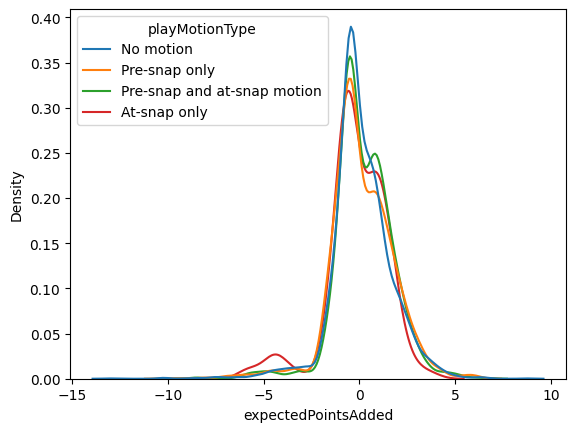

In [9]:
sns.kdeplot(data=data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).collect(), x="expectedPointsAdded", hue="playMotionType", common_norm=False)

<Axes: xlabel='expectedPointsAdded', ylabel='Density'>

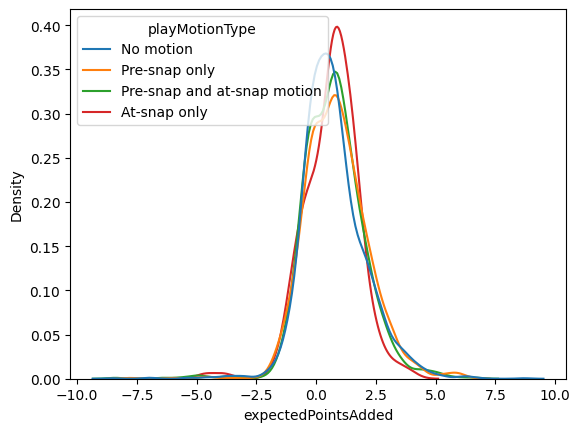

In [25]:
sns.kdeplot(data=data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        filter(pl.col("passResult") == "C").collect(), x="expectedPointsAdded", hue="playMotionType", common_norm=False)

In [18]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        group_by([pl.col("playType"), pl.col("playMotionType"), pl.col("playerPreSnapMotionWasTargetted")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType", "playMotionType").\
collect()

shape: (7, 11)
┌─────────┬────────┬────────┬───────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ playTyp ┆ playMo ┆ player ┆ count ┆ comple ┆ motion ┆ avg_pa ┆ avg_ep ┆ median ┆ avg_wp ┆ median │
│ e       ┆ tionTy ┆ PreSna ┆ ---   ┆ tion_p ┆ _targe ┆ ss_len ┆ a_adde ┆ _epa_a ┆ _added ┆ _wp_ad │
│ ---     ┆ pe     ┆ pMotio ┆ u32   ┆ ercent ┆ t_perc ┆ gth    ┆ d      ┆ dded   ┆ ---    ┆ ded    │
│ str     ┆ ---    ┆ nWasTa ┆       ┆ age    ┆ entage ┆ ---    ┆ ---    ┆ ---    ┆ f64    ┆ ---    │
│         ┆ str    ┆ rgette ┆       ┆ ---    ┆ ---    ┆ f64    ┆ f64    ┆ f64    ┆        ┆ f64    │
│         ┆        ┆ …      ┆       ┆ f64    ┆ f64    ┆        ┆        ┆        ┆        ┆        │
│         ┆        ┆ ---    ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆        ┆ u32    ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
╞═════════╪════════╪════════╪═══════╪════════╪════════╪════════╪════════╪════════╪════════╪════════╡
│ pass    ┆ At-sna ┆ 1      ┆ 24    ┆ 0.0    ┆ 1.0    ┆ 6.5416 ┆ -1.391 ┆ -0.898 ┆ -0.032 ┆ -0.011 │
│         ┆ p only ┆        ┆       ┆        ┆        ┆ 67     ┆ 025    ┆ 907    ┆ 911    ┆ 17     │
│ pass    ┆ At-sna ┆ 0      ┆ 290   ┆ 0.6551 ┆ 0.0    ┆ 6.9758 ┆ -0.026 ┆ -0.083 ┆ -0.002 ┆ -0.000 │
│         ┆ p only ┆        ┆       ┆ 72     ┆        ┆ 62     ┆ 413    ┆ 844    ┆ 677    ┆ 276    │
│ pass    ┆ No     ┆ 0      ┆ 4027  ┆ 0.6630 ┆ 0.0    ┆ 8.2761 ┆ 0.1080 ┆ -0.078 ┆ 0.0026 ┆ -0.000 │
│         ┆ motion ┆        ┆       ┆ 25     ┆        ┆ 36     ┆ 24     ┆ 975    ┆ 34     ┆ 143    │
│ pass    ┆ Pre-sn ┆ 1      ┆ 601   ┆ 0.7770 ┆ 1.0    ┆ 3.6821 ┆ 0.2279 ┆ 0.0244 ┆ 0.0068 ┆ 0.0001 │
│         ┆ ap and ┆        ┆       ┆ 38     ┆        ┆ 96     ┆ 6      ┆ 86     ┆ 85     ┆ 72     │
│         ┆ at-sna ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ p      ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ motion ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│ pass    ┆ Pre-sn ┆ 0      ┆ 1162  ┆ 0.7005 ┆ 0.0    ┆ 7.1927 ┆ 0.2469 ┆ 0.1388 ┆ 0.0046 ┆ 0.0005 │
│         ┆ ap and ┆        ┆       ┆ 16     ┆        ┆ 71     ┆ 29     ┆ 49     ┆ 02     ┆ 1      │
│         ┆ at-sna ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ p      ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│         ┆ motion ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│ pass    ┆ Pre-sn ┆ 0      ┆ 1677  ┆ 0.6308 ┆ 0.0    ┆ 9.1234 ┆ 0.1336 ┆ -0.064 ┆ 0.0036 ┆ -0.000 │
│         ┆ ap     ┆        ┆       ┆ 88     ┆        ┆ 35     ┆ 96     ┆ 331    ┆ 53     ┆ 103    │
│         ┆ only   ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
│ pass    ┆ Pre-sn ┆ 1      ┆ 591   ┆ 0.7191 ┆ 1.0    ┆ 5.2707 ┆ 0.0891 ┆ -0.088 ┆ 0.0022 ┆ -0.000 │
│         ┆ ap     ┆        ┆       ┆ 2      ┆        ┆ 28     ┆ 17     ┆ 225    ┆ 8      ┆ 261    │
│         ┆ only   ┆        ┆       ┆        ┆        ┆        ┆        ┆        ┆        ┆        │
└─────────┴────────┴────────┴───────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘

In [22]:
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playTargets") > 0).\
        group_by([pl.col("playType"), pl.col("playHadPreSnapMotion")]).\
            agg(count=pl.count("playId"), 
                completion_percentage = (pl.col("passResult") == "C").sum() / pl.count("playId"),
                motion_target_percentage = pl.mean("playerPreSnapMotionWasTargetted"),
                avg_pass_length=pl.col("passLength").cast(pl.Float64).mean(),
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort("playType", "playHadPreSnapMotion").\
collect()

shape: (2, 10)
┌──────────┬─────────┬───────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ playType ┆ playHad ┆ count ┆ complet ┆ motion_ ┆ avg_pas ┆ avg_epa ┆ median_ ┆ avg_wp_ ┆ median_ │
│ ---      ┆ PreSnap ┆ ---   ┆ ion_per ┆ target_ ┆ s_lengt ┆ _added  ┆ epa_add ┆ added   ┆ wp_adde │
│ str      ┆ Motion  ┆ u32   ┆ centage ┆ percent ┆ h       ┆ ---     ┆ ed      ┆ ---     ┆ d       │
│          ┆ ---     ┆       ┆ ---     ┆ age     ┆ ---     ┆ f64     ┆ ---     ┆ f64     ┆ ---     │
│          ┆ bool    ┆       ┆ f64     ┆ ---     ┆ f64     ┆         ┆ f64     ┆         ┆ f64     │
│          ┆         ┆       ┆         ┆ f64     ┆         ┆         ┆         ┆         ┆         │
╞══════════╪═════════╪═══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ pass     ┆ false   ┆ 4027  ┆ 0.66302 ┆ 0.0     ┆ 8.27613 ┆ 0.10802 ┆ -0.0789 ┆ 0.00263 ┆ -0.0001 │
│          ┆         ┆       ┆ 5       ┆         ┆ 6       ┆ 4       ┆ 75      ┆ 4       ┆ 43      │
│ pass     ┆ true    ┆ 4345  ┆ 0.67986 ┆ 0.27986 ┆ 7.17284 ┆ 0.15184 ┆ -0.0230 ┆ 0.00354 ┆ -0.0000 │
│          ┆         ┆       ┆ 2       ┆ 2       ┆ 2       ┆ 5       ┆ 82      ┆ 3       ┆ 14      │
└──────────┴─────────┴───────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘

In [20]:
# Plays where there was presnap motion and motion at snap, but motion player was not targeted
data.\
    plays_df.\
        filter(pl.col("playType") == "pass").\
        filter(pl.col("playMotionType") == "Pre-snap and at-snap motion").\
        filter(pl.col("expectedPointsAdded") > 0.2).\
        filter(pl.col("playerPreSnapMotionWasTargetted") == 0).collect().sort("expectedPointsAdded").head(20)

shape: (20, 85)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ pla ┆ qua ┆ dow ┆ yar ┆ pos ┆ def ┆ yar ┆ yar ┆ gam ┆ pre ┆ pre ┆ pla ┆ abs ┆ pre ┆ pre ┆ exp ┆ off ┆ rec ┆ pla ┆ pas ┆ pas ┆ tar ┆ tar ┆ pla ┆ dro ┆ dro ┆ pas ┆ tim ┆ tim ┆ tim ┆ pas ┆ unb ┆ qbS ┆ qbK ┆ qbS ┆ rus ┆ pen ┆ pre ┆ yar ┆ hom ┆ vis ┆ exp ┆ isD ┆ pff ┆ pff ┆ pff ┆ pff ┆ pff ┆ sea ┆ wee ┆ gam ┆ gam ┆ hom ┆ vis ┆ hom ┆ vis ┆ dis ┆ pla ┆ pre ┆ pre ┆ pre ┆ pre ┆ pos ┆ def ┆ def ┆ sco ┆ pos ┆ pos ┆ pos ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ yar ┆ def ┆ def ┆ def │
│ eId ┆ yId ┆ yDe ┆ rte ┆ n   ┆ dsT ┆ ses ┆ ens ┆ dli ┆ dli ┆ eCl ┆ Sna ┆ Sna ┆ yNu ┆ olu ┆ Sna ┆ Sna ┆ ect ┆ ens ┆ eiv ┆ yCl ┆ sRe ┆ sLe ┆ get ┆ get ┆ yAc ┆ pba ┆ pba ┆ sLo ┆ eTo ┆ eIn ┆ eTo ┆ sTi ┆ loc ┆ pik ┆ nee ┆ nea ┆ hLo ┆ alt ┆ Pen ┆ dsG ┆ eTe ┆ ito ┆ ect ┆ rop ┆ _ru ┆ _ru ┆ _ru ┆ _pa ┆ _ma ┆ son ┆ k   ┆ eDa ┆ eTi ┆ eTe ┆ ito ┆ eFi ┆ ito ┆ tan ┆ yTy ┆ Sna ┆ Sna ┆ Sna ┆ Sna ┆ ses ┆ ens ┆ ens ┆ reD ┆ ses ┆ ses ┆ ses ┆ yTa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yer ┆ yer ┆ yer ┆ yMo ┆ dsA ┆ ens ┆ ens ┆ ens │
│ --- ┆ --- ┆ scr ┆ r   ┆ --- ┆ oGo ┆ sio ┆ ive ┆ neS ┆ neN ┆ ock ┆ pHo ┆ pVi ┆ lli ┆ teY ┆ pHo ┆ pVi ┆ edP ┆ eFo ┆ erA ┆ ock ┆ sul ┆ ngt ┆ X   ┆ Y   ┆ tio ┆ ckT ┆ ckD ┆ cat ┆ Thr ┆ Tac ┆ Sac ┆ ppe ┆ ked ┆ e   ┆ l   ┆ k   ┆ cat ┆ yYa ┆ alt ┆ ain ┆ amW ┆ rTe ┆ edP ┆ bac ┆ nCo ┆ nCo ┆ nPa ┆ ssC ┆ nZo ┆ --- ┆ --- ┆ te  ┆ meE ┆ amA ┆ rTe ┆ nal ┆ rFi ┆ ceT ┆ pe  ┆ pPo ┆ pDe ┆ pPo ┆ pDe ┆ sio ┆ ive ┆ ive ┆ iff ┆ sio ┆ sio ┆ sio ┆ rge ┆ dPl ┆ dPl ┆ dPl ┆ dMo ┆ dPr ┆ Mot ┆ InM ┆ Pre ┆ tio ┆ fte ┆ ive ┆ ive ┆ ive │
│ i64 ┆ i64 ┆ ipt ┆ --- ┆ i64 ┆ --- ┆ nTe ┆ Tea ┆ ide ┆ umb ┆ --- ┆ meS ┆ sit ┆ fie ┆ ard ┆ meT ┆ sit ┆ oin ┆ rma ┆ lig ┆ AtS ┆ t   ┆ h   ┆ --- ┆ --- ┆ n   ┆ ype ┆ ist ┆ ion ┆ ow  ┆ kle ┆ k   ┆ dAt ┆ Pre ┆ --- ┆ --- ┆ --- ┆ ion ┆ rds ┆ yYa ┆ ed  ┆ inP ┆ amW ┆ oin ┆ k   ┆ nce ┆ nce ┆ ssO ┆ ove ┆ ne  ┆ i64 ┆ i64 ┆ --- ┆ ast ┆ bbr ┆ amA ┆ Sco ┆ nal ┆ oEn ┆ --- ┆ sse ┆ fen ┆ sse ┆ fen ┆ nTe ┆ Tea ┆ Tea ┆ ere ┆ nTe ┆ nTe ┆ nTe ┆ ts  ┆ aye ┆ aye ┆ aye ┆ tio ┆ eSn ┆ ion ┆ oti ┆ Sna ┆ nTy ┆ rCa ┆ Tea ┆ Tea ┆ Tea │
│     ┆     ┆ ion ┆ i64 ┆     ┆ i64 ┆ am  ┆ m   ┆ --- ┆ er  ┆ str ┆ cor ┆ orS ┆ dBy ┆ lin ┆ eam ┆ orT ┆ ts  ┆ tio ┆ nme ┆ nap ┆ --- ┆ --- ┆ str ┆ str ┆ --- ┆ --- ┆ anc ┆ Typ ┆ --- ┆ Box ┆ --- ┆ Lin ┆ ssu ┆ str ┆ i64 ┆ str ┆ Typ ┆ --- ┆ rds ┆ --- ┆ rob ┆ inP ┆ tsA ┆ --- ┆ ptP ┆ ptS ┆ pti ┆ rag ┆ --- ┆     ┆     ┆ str ┆ ern ┆ --- ┆ bbr ┆ re  ┆ Sco ┆ dzo ┆ str ┆ ssi ┆ siv ┆ ssi ┆ siv ┆ amW ┆ mWP ┆ mEx ┆ nce ┆ amN ┆ amN ┆ amN ┆ --- ┆ rsI ┆ rsM ┆ rsS ┆ nAn ┆ apM ┆ Cam ┆ onA ┆ pMo ┆ pe  ┆ tch ┆ mNu ┆ mNu ┆ mNu │
│     ┆     ┆ --- ┆     ┆     ┆     ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ e   ┆ cor ┆ Pen ┆ eNu ┆ Win ┆ eam ┆ --- ┆ n   ┆ nt  ┆ --- ┆ str ┆ str ┆     ┆     ┆ boo ┆ str ┆ e   ┆ e   ┆ str ┆ --- ┆ str ┆ e   ┆ re  ┆     ┆     ┆     ┆ e   ┆ str ┆ Gai ┆ i64 ┆ abi ┆ rob ┆ dde ┆ boo ┆ rim ┆ eco ┆ on  ┆ e   ┆ str ┆     ┆     ┆     ┆ --- ┆ str ┆ --- ┆ --- ┆ re  ┆ ne  ┆     ┆ onT ┆ eTe ┆ onT ┆ eTe ┆ PAd ┆ Add ┆ pec ┆ --- ┆ umP ┆ umP ┆ umP ┆ i64 ┆ nMo ┆ oti ┆ hif ┆ dCa ┆ oti ┆ eSe ┆ tSn ┆ tio ┆ --- ┆ --- ┆ mPl ┆ mPl ┆ mPl │
│     ┆     ┆ str ┆     ┆     ┆     ┆ str ┆ str ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆ alt ┆ mbe ┆ Pro ┆ Win ┆ f64 ┆ --- ┆ --- ┆ i64 ┆     ┆     ┆     ┆     ┆ l   ┆     ┆ --- ┆ --- ┆     ┆ str ┆     ┆ --- ┆ --- ┆     ┆     ┆     ┆ --- ┆     ┆ ned ┆     ┆ lit ┆ ili ┆ d   ┆ l   ┆ ary ┆ nda ┆ --- ┆ --- ┆     ┆     ┆     ┆     ┆ str ┆     ┆ str ┆ i64 ┆ --- ┆ --- ┆     ┆ eam ┆ amS ┆ eam ┆ amW ┆ ded ┆ ed  ┆ te

In [21]:
play = PlotPlayVertical(data.tracking_data.filter((pl.col("gameId") == 2022092501) & (pl.col("playId") == 2792)).collect())
play.animate_play()

In [24]:
# Plays where there was presnap motion and motion at snap, but motion player was not targeted
data.\
    plays_df.\
        filter(pl.col("playMotionType") == "Pre-snap and at-snap motion").\
        filter(pl.col("playerPreSnapMotionWasTargetted") == 0).collect().group_by("possessionTeam").agg(count=pl.count("playId")).sort("count", descending=True)

shape: (32, 2)
┌────────────────┬───────┐
│ possessionTeam ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ MIA            ┆ 158   │
│ NYJ            ┆ 133   │
│ BAL            ┆ 113   │
│ TB             ┆ 106   │
│ ATL            ┆ 105   │
│ KC             ┆ 104   │
│ JAX            ┆ 94    │
│ WAS            ┆ 92    │
│ DET            ┆ 88    │
│ SF             ┆ 81    │
│ CLE            ┆ 79    │
│ MIN            ┆ 78    │
│ NYG            ┆ 77    │
│ BUF            ┆ 75    │
│ LA             ┆ 75    │
│ DAL            ┆ 70    │
│ PIT            ┆ 70    │
│ LV             ┆ 64    │
│ IND            ┆ 63    │
│ NO             ┆ 61    │
│ DEN            ┆ 61    │
│ NE             ┆ 58    │
│ CHI            ┆ 56    │
│ LAC            ┆ 54    │
│ CAR            ┆ 53    │
│ GB             ┆ 53    │
│ ARI            ┆ 49    │
│ TEN            ┆ 47    │
│ CIN            ┆ 44    │
│ HOU            ┆ 41    │
│ SEA            ┆ 39    │
│ PHI            ┆ 34    │
└────────────────┴───────┘

In [16]:
data.plays_df.collect().head()

shape: (5, 84)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ pla ┆ qua ┆ dow ┆ yar ┆ pos ┆ def ┆ yar ┆ yar ┆ gam ┆ pre ┆ pre ┆ pla ┆ abs ┆ pre ┆ pre ┆ exp ┆ off ┆ rec ┆ pla ┆ pas ┆ pas ┆ tar ┆ tar ┆ pla ┆ dro ┆ dro ┆ pas ┆ tim ┆ tim ┆ tim ┆ pas ┆ unb ┆ qbS ┆ qbK ┆ qbS ┆ rus ┆ pen ┆ pre ┆ yar ┆ hom ┆ vis ┆ exp ┆ isD ┆ pff ┆ pff ┆ pff ┆ pff ┆ pff ┆ sea ┆ wee ┆ gam ┆ gam ┆ hom ┆ vis ┆ hom ┆ vis ┆ dis ┆ pla ┆ pre ┆ pre ┆ pre ┆ pre ┆ pos ┆ def ┆ def ┆ sco ┆ pos ┆ pos ┆ pos ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ def ┆ def ┆ def │
│ eId ┆ yId ┆ yDe ┆ rte ┆ n   ┆ dsT ┆ ses ┆ ens ┆ dli ┆ dli ┆ eCl ┆ Sna ┆ Sna ┆ yNu ┆ olu ┆ Sna ┆ Sna ┆ ect ┆ ens ┆ eiv ┆ yCl ┆ sRe ┆ sLe ┆ get ┆ get ┆ yAc ┆ pba ┆ pba ┆ sLo ┆ eTo ┆ eIn ┆ eTo ┆ sTi ┆ loc ┆ pik ┆ nee ┆ nea ┆ hLo ┆ alt ┆ Pen ┆ dsG ┆ eTe ┆ ito ┆ ect ┆ rop ┆ _ru ┆ _ru ┆ _ru ┆ _pa ┆ _ma ┆ son ┆ k   ┆ eDa ┆ eTi ┆ eTe ┆ ito ┆ eFi ┆ ito ┆ tan ┆ yTy ┆ Sna ┆ Sna ┆ Sna ┆ Sna ┆ ses ┆ ens ┆ ens ┆ reD ┆ ses ┆ ses ┆ ses ┆ yTa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yHa ┆ yer ┆ yer ┆ yer ┆ yMo ┆ ens ┆ ens ┆ ens │
│ --- ┆ --- ┆ scr ┆ r   ┆ --- ┆ oGo ┆ sio ┆ ive ┆ neS ┆ neN ┆ ock ┆ pHo ┆ pVi ┆ lli ┆ teY ┆ pHo ┆ pVi ┆ edP ┆ eFo ┆ erA ┆ ock ┆ sul ┆ ngt ┆ X   ┆ Y   ┆ tio ┆ ckT ┆ ckD ┆ cat ┆ Thr ┆ Tac ┆ Sac ┆ ppe ┆ ked ┆ e   ┆ l   ┆ k   ┆ cat ┆ yYa ┆ alt ┆ ain ┆ amW ┆ rTe ┆ edP ┆ bac ┆ nCo ┆ nCo ┆ nPa ┆ ssC ┆ nZo ┆ --- ┆ --- ┆ te  ┆ meE ┆ amA ┆ rTe ┆ nal ┆ rFi ┆ ceT ┆ pe  ┆ pPo ┆ pDe ┆ pPo ┆ pDe ┆ sio ┆ ive ┆ ive ┆ iff ┆ sio ┆ sio ┆ sio ┆ rge ┆ dPl ┆ dPl ┆ dPl ┆ dMo ┆ dPr ┆ Mot ┆ InM ┆ Pre ┆ tio ┆ ive ┆ ive ┆ ive │
│ i64 ┆ i64 ┆ ipt ┆ --- ┆ i64 ┆ --- ┆ nTe ┆ Tea ┆ ide ┆ umb ┆ --- ┆ meS ┆ sit ┆ fie ┆ ard ┆ meT ┆ sit ┆ oin ┆ rma ┆ lig ┆ AtS ┆ t   ┆ h   ┆ --- ┆ --- ┆ n   ┆ ype ┆ ist ┆ ion ┆ ow  ┆ kle ┆ k   ┆ dAt ┆ Pre ┆ --- ┆ --- ┆ --- ┆ ion ┆ rds ┆ yYa ┆ ed  ┆ inP ┆ amW ┆ oin ┆ k   ┆ nce ┆ nce ┆ ssO ┆ ove ┆ ne  ┆ i64 ┆ i64 ┆ --- ┆ ast ┆ bbr ┆ amA ┆ Sco ┆ nal ┆ oEn ┆ --- ┆ sse ┆ fen ┆ sse ┆ fen ┆ nTe ┆ Tea ┆ Tea ┆ ere ┆ nTe ┆ nTe ┆ nTe ┆ ts  ┆ aye ┆ aye ┆ aye ┆ tio ┆ eSn ┆ ion ┆ oti ┆ Sna ┆ nTy ┆ Tea ┆ Tea ┆ Tea │
│     ┆     ┆ ion ┆ i64 ┆     ┆ i64 ┆ am  ┆ m   ┆ --- ┆ er  ┆ str ┆ cor ┆ orS ┆ dBy ┆ lin ┆ eam ┆ orT ┆ ts  ┆ tio ┆ nme ┆ nap ┆ --- ┆ --- ┆ str ┆ str ┆ --- ┆ --- ┆ anc ┆ Typ ┆ --- ┆ Box ┆ --- ┆ Lin ┆ ssu ┆ str ┆ i64 ┆ str ┆ Typ ┆ --- ┆ rds ┆ --- ┆ rob ┆ inP ┆ tsA ┆ --- ┆ ptP ┆ ptS ┆ pti ┆ rag ┆ --- ┆     ┆     ┆ str ┆ ern ┆ --- ┆ bbr ┆ re  ┆ Sco ┆ dzo ┆ str ┆ ssi ┆ siv ┆ ssi ┆ siv ┆ amW ┆ mWP ┆ mEx ┆ nce ┆ amN ┆ amN ┆ amN ┆ --- ┆ rsI ┆ rsM ┆ rsS ┆ nAn ┆ apM ┆ Cam ┆ onA ┆ pMo ┆ pe  ┆ mNu ┆ mNu ┆ mNu │
│     ┆     ┆ --- ┆     ┆     ┆     ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ e   ┆ cor ┆ Pen ┆ eNu ┆ Win ┆ eam ┆ --- ┆ n   ┆ nt  ┆ --- ┆ str ┆ str ┆     ┆     ┆ boo ┆ str ┆ e   ┆ e   ┆ str ┆ --- ┆ str ┆ e   ┆ re  ┆     ┆     ┆     ┆ e   ┆ str ┆ Gai ┆ i64 ┆ abi ┆ rob ┆ dde ┆ boo ┆ rim ┆ eco ┆ on  ┆ e   ┆ str ┆     ┆     ┆     ┆ --- ┆ str ┆ --- ┆ --- ┆ re  ┆ ne  ┆     ┆ onT ┆ eTe ┆ onT ┆ eTe ┆ PAd ┆ Add ┆ pec ┆ --- ┆ umP ┆ umP ┆ umP ┆ i64 ┆ nMo ┆ oti ┆ hif ┆ dCa ┆ oti ┆ eSe ┆ tSn ┆ tio ┆ --- ┆ mPl ┆ mPl ┆ mPl │
│     ┆     ┆ str ┆     ┆     ┆     ┆ str ┆ str ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆ alt ┆ mbe ┆ Pro ┆ Win ┆ f64 ┆ --- ┆ --- ┆ i64 ┆     ┆     ┆     ┆     ┆ l   ┆     ┆ --- ┆ --- ┆     ┆ str ┆     ┆ --- ┆ --- ┆     ┆     ┆     ┆ --- ┆     ┆ ned ┆     ┆ lit ┆ ili ┆ d   ┆ l   ┆ ary ┆ nda ┆ --- ┆ --- ┆     ┆     ┆     ┆     ┆ str ┆     ┆ str ┆ i64 ┆ --- ┆ --- ┆     ┆ eam ┆ amS ┆ eam ┆ amW ┆ ded ┆ ed  ┆ ted ┆ i64 ┆ lay ┆ lay ┆ lay ┆     ┆ tio ┆ onS

In [7]:
data.\
    plays_df.\
    filter(pl.col("playType") == "pass").\
    filter(pl.col("passResult").is_in(["C", "I", "IN"])).\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort(["playType", "playMotionType", "playerPreSnapMotionWasTargetted"]).\
collect()

shape: (7, 8)
┌──────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬────────────┬────────────┐
│ playType ┆ playMotionT ┆ playerPreSn ┆ count ┆ avg_epa_ad ┆ median_epa ┆ avg_wp_add ┆ median_wp_ │
│ ---      ┆ ype         ┆ apMotionWas ┆ ---   ┆ ded        ┆ _added     ┆ ed         ┆ added      │
│ str      ┆ ---         ┆ Targette…   ┆ u32   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│          ┆ str         ┆ ---         ┆       ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
│          ┆             ┆ u32         ┆       ┆            ┆            ┆            ┆            │
╞══════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪════════════╪════════════╡
│ pass     ┆ At-snap     ┆ 0           ┆ 310   ┆ -0.080033  ┆ -0.267312  ┆ -0.003874  ┆ -0.001053  │
│          ┆ only        ┆             ┆       ┆            ┆            ┆            ┆            │
│ pass     ┆ At-snap     ┆ 1           ┆ 24    ┆ -1.391025  ┆ -0.898907  ┆ -0.032911  ┆ -0.01117   │
│          ┆ only        ┆             ┆       ┆            ┆            ┆            ┆            │
│ pass     ┆ No motion   ┆ 0           ┆ 4203  ┆ 0.077589   ┆ -0.12607   ┆ 0.001698   ┆ -0.000368  │
│ pass     ┆ Pre-snap    ┆ 0           ┆ 1229  ┆ 0.192282   ┆ 0.008656   ┆ 0.003143   ┆ 0.0        │
│          ┆ and at-snap ┆             ┆       ┆            ┆            ┆            ┆            │
│          ┆ motion      ┆             ┆       ┆            ┆            ┆            ┆            │
│ pass     ┆ Pre-snap    ┆ 1           ┆ 601   ┆ 0.22796    ┆ 0.024486   ┆ 0.006885   ┆ 0.000172   │
│          ┆ and at-snap ┆             ┆       ┆            ┆            ┆            ┆            │
│          ┆ motion      ┆             ┆       ┆            ┆            ┆            ┆            │
│ pass     ┆ Pre-snap    ┆ 0           ┆ 1770  ┆ 0.074815   ┆ -0.205488  ┆ 0.002345   ┆ -0.000842  │
│          ┆ only        ┆             ┆       ┆            ┆            ┆            ┆            │
│ pass     ┆ Pre-snap    ┆ 1           ┆ 591   ┆ 0.089117   ┆ -0.088225  ┆ 0.00228    ┆ -0.000261  │
│          ┆ only        ┆             ┆       ┆            ┆            ┆            ┆            │
└──────────┴─────────────┴─────────────┴───────┴────────────┴────────────┴────────────┴────────────┘

In [8]:
data.\
    plays_df.\
        group_by([pl.col("playType"), pl.col("playHadPlayersInMotionAtSnap")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort(["playType", "playHadPlayersInMotionAtSnap"]).\
collect()

shape: (4, 7)
┌──────────┬────────────────┬───────┬───────────────┬───────────────┬──────────────┬───────────────┐
│ playType ┆ playHadPlayers ┆ count ┆ avg_epa_added ┆ median_epa_ad ┆ avg_wp_added ┆ median_wp_add │
│ ---      ┆ InMotionAtSnap ┆ ---   ┆ ---           ┆ ded           ┆ ---          ┆ ed            │
│ str      ┆ ---            ┆ u32   ┆ f64           ┆ ---           ┆ f64          ┆ ---           │
│          ┆ bool           ┆       ┆               ┆ f64           ┆              ┆ f64           │
╞══════════╪════════════════╪═══════╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ pass     ┆ false          ┆ 7351  ┆ -0.032469     ┆ -0.225525     ┆ -0.00047     ┆ -0.001025     │
│ pass     ┆ true           ┆ 2385  ┆ 0.048977      ┆ -0.159179     ┆ 0.000747     ┆ -0.000661     │
│ run      ┆ false          ┆ 4293  ┆ -0.055562     ┆ -0.13777      ┆ 0.000233     ┆ -0.000051     │
│ run      ┆ true           ┆ 2095  ┆ -0.054101     ┆ -0.175659     ┆ 0.000437     ┆ -0.000291     │
└──────────┴────────────────┴───────┴───────────────┴───────────────┴──────────────┴───────────────┘

In [9]:
data.plays_df.group_by(["passResult", "playTargets"]).agg(count=pl.count("playId")).collect().sort("passResult")

shape: (9, 3)
┌────────────┬─────────────┬───────┐
│ passResult ┆ playTargets ┆ count │
│ ---        ┆ ---         ┆ ---   │
│ str        ┆ i64         ┆ u32   │
╞════════════╪═════════════╪═══════╡
│            ┆ 0           ┆ 6388  │
│ C          ┆ 1           ┆ 5624  │
│ I          ┆ 1           ┆ 2557  │
│ I          ┆ 0           ┆ 354   │
│ IN         ┆ 1           ┆ 190   │
│ IN         ┆ 0           ┆ 3     │
│ R          ┆ 0           ┆ 399   │
│ R          ┆ 1           ┆ 1     │
│ S          ┆ 0           ┆ 608   │
└────────────┴─────────────┴───────┘

In [10]:
data.\
    plays_df.\
    filter(pl.col("playTargets")==1).\
        group_by([pl.col("playType"), pl.col("playMotionType")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort(["playType", "playMotionType"]).\
collect()

shape: (4, 7)
┌──────────┬────────────────┬───────┬───────────────┬───────────────┬──────────────┬───────────────┐
│ playType ┆ playMotionType ┆ count ┆ avg_epa_added ┆ median_epa_ad ┆ avg_wp_added ┆ median_wp_add │
│ ---      ┆ ---            ┆ ---   ┆ ---           ┆ ded           ┆ ---          ┆ ed            │
│ str      ┆ str            ┆ u32   ┆ f64           ┆ ---           ┆ f64          ┆ ---           │
│          ┆                ┆       ┆               ┆ f64           ┆              ┆ f64           │
╞══════════╪════════════════╪═══════╪═══════════════╪═══════════════╪══════════════╪═══════════════╡
│ pass     ┆ At-snap only   ┆ 314   ┆ -0.130715     ┆ -0.305647     ┆ -0.004988    ┆ -0.001122     │
│ pass     ┆ No motion      ┆ 4027  ┆ 0.108024      ┆ -0.078975     ┆ 0.002634     ┆ -0.000143     │
│ pass     ┆ Pre-snap and   ┆ 1763  ┆ 0.240463      ┆ 0.082278      ┆ 0.00538      ┆ 0.000371      │
│          ┆ at-snap motion ┆       ┆               ┆               ┆              ┆               │
│ pass     ┆ Pre-snap only  ┆ 2268  ┆ 0.122079      ┆ -0.077025     ┆ 0.003295     ┆ -0.000156     │
└──────────┴────────────────┴───────┴───────────────┴───────────────┴──────────────┴───────────────┘

In [13]:
data.\
    plays_df.\
    filter(pl.col("playTargets")==1).\
        group_by([pl.col("playType"), pl.col("playHadPlayersInMotionAtSnap"), pl.col("playerInMotionAtSnapWasTargetted")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort(["playType", "playHadPlayersInMotionAtSnap"]).\
collect()

shape: (3, 8)
┌──────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬────────────┬────────────┐
│ playType ┆ playHadPlay ┆ playerInMot ┆ count ┆ avg_epa_ad ┆ median_epa ┆ avg_wp_add ┆ median_wp_ │
│ ---      ┆ ersInMotion ┆ ionAtSnapWa ┆ ---   ┆ ded        ┆ _added     ┆ ed         ┆ added      │
│ str      ┆ AtSnap      ┆ sTargett…   ┆ u32   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│          ┆ ---         ┆ ---         ┆       ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
│          ┆ bool        ┆ u32         ┆       ┆            ┆            ┆            ┆            │
╞══════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪════════════╪════════════╡
│ pass     ┆ false       ┆ 0           ┆ 6295  ┆ 0.113088   ┆ -0.078201  ┆ 0.002872   ┆ -0.000143  │
│ pass     ┆ true        ┆ 1           ┆ 566   ┆ 0.154519   ┆ -0.091821  ┆ 0.004731   ┆ -0.000485  │
│ pass     ┆ true        ┆ 0           ┆ 1511  ┆ 0.195522   ┆ 0.089118   ┆ 0.003468   ┆ 0.000271   │
└──────────┴─────────────┴─────────────┴───────┴────────────┴────────────┴────────────┴────────────┘

In [12]:
data.\
    plays_df.\
    filter(pl.col("playTargets")==1).\
        group_by([pl.col("playType"), pl.col("playHadPlayersInMotionAtSnap"), pl.col("playerInMotionAtSnapWasTargetted"), pl.col("passResult")]).\
            agg(count=pl.count("playId"), 
                avg_epa_added=pl.mean("expectedPointsAdded"), 
                median_epa_added = pl.median("expectedPointsAdded"),
                avg_wp_added = pl.mean("possessionTeamWPAdded"),
                median_wp_added = pl.median("possessionTeamWPAdded")).\
        sort(["playType", "playHadPlayersInMotionAtSnap", "passResult"]).\
collect()

shape: (10, 9)
┌──────────┬───────────┬───────────┬───────────┬───────┬──────────┬──────────┬──────────┬──────────┐
│ playType ┆ playHadPl ┆ playerInM ┆ passResul ┆ count ┆ avg_epa_ ┆ median_e ┆ avg_wp_a ┆ median_w │
│ ---      ┆ ayersInMo ┆ otionAtSn ┆ t         ┆ ---   ┆ added    ┆ pa_added ┆ dded     ┆ p_added  │
│ str      ┆ tionAtSna ┆ apWasTarg ┆ ---       ┆ u32   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│          ┆ p         ┆ ett…      ┆ str       ┆       ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
│          ┆ ---       ┆ ---       ┆           ┆       ┆          ┆          ┆          ┆          │
│          ┆ bool      ┆ u32       ┆           ┆       ┆          ┆          ┆          ┆          │
╞══════════╪═══════════╪═══════════╪═══════════╪═══════╪══════════╪══════════╪══════════╪══════════╡
│ pass     ┆ false     ┆ 0         ┆ C         ┆ 4153  ┆ 0.782185 ┆ 0.659443 ┆ 0.018981 ┆ 0.008208 │
│ pass     ┆ false     ┆ 0         ┆ I         ┆ 1994  ┆ -0.92503 ┆ -0.76652 ┆ -0.02259 ┆ -0.01561 │
│          ┆           ┆           ┆           ┆       ┆ 9        ┆ 8        ┆ 9        ┆ 2        │
│ pass     ┆ false     ┆ 0         ┆ IN        ┆ 147   ┆ -4.69569 ┆ -4.54710 ┆ -0.10653 ┆ -0.09611 │
│          ┆           ┆           ┆           ┆       ┆ 8        ┆ 6        ┆ 3        ┆ 3        │
│ pass     ┆ false     ┆ 0         ┆ R         ┆ 1     ┆ -1.72919 ┆ -1.72919 ┆ -0.02323 ┆ -0.02323 │
│          ┆           ┆           ┆           ┆       ┆          ┆          ┆ 7        ┆ 7        │
│ pass     ┆ true      ┆ 0         ┆ C         ┆ 1050  ┆ 0.78956  ┆ 0.762177 ┆ 0.017512 ┆ 0.011011 │
│ pass     ┆ true      ┆ 1         ┆ C         ┆ 421   ┆ 0.611109 ┆ 0.64094  ┆ 0.015203 ┆ 0.007672 │
│ pass     ┆ true      ┆ 0         ┆ I         ┆ 427   ┆ -0.87755 ┆ -0.75687 ┆ -0.02151 ┆ -0.01526 │
│          ┆           ┆           ┆           ┆       ┆ 8        ┆ 4        ┆ 9        ┆          │
│ pass     ┆ true      ┆ 1         ┆ I         ┆ 136   ┆ -0.92072 ┆ -0.76456 ┆ -0.02117 ┆ -0.01168 │
│          ┆           ┆           ┆           ┆       ┆ 6        ┆ 3        ┆ 1        ┆ 5        │
│ pass     ┆ true      ┆ 0         ┆ IN        ┆ 34    ┆ -4.67315 ┆ -4.65171 ┆ -0.11640 ┆ -0.09262 │
│          ┆           ┆           ┆           ┆       ┆ 3        ┆ 9        ┆ 3        ┆ 7        │
│ pass     ┆ true      ┆ 1         ┆ IN        ┆ 9     ┆ -4.95558 ┆ -4.85848 ┆ -0.09371 ┆ -0.09540 │
│          ┆           ┆           ┆           ┆       ┆ 4        ┆ 6        ┆ 3        ┆ 7        │
└──────────┴───────────┴───────────┴───────────┴───────┴──────────┴──────────┴──────────┴──────────┘

In [13]:
4153 + 1994 + 147 + 1

6295

Consider all plays that had at least one player in motion. 

In [4]:
data.plays_df.\
    group_by(["playType", "playHadMotion"]).\
        agg(count=pl.count("playId"), 
            avg_epa_added=pl.mean("expectedPointsAdded"), 
            median_epa_added = pl.median("expectedPointsAdded"),
            avg_wp_added = pl.mean("possessionTeamWPAdded"),
            median_wp_added = pl.median("possessionTeamWPAdded")).\
    sort("playType", "playHadMotion").\
    collect()

shape: (4, 7)
┌──────────┬───────────────┬───────┬───────────────┬────────────────┬──────────────┬───────────────┐
│ playType ┆ playHadMotion ┆ count ┆ avg_epa_added ┆ median_epa_add ┆ avg_wp_added ┆ median_wp_add │
│ ---      ┆ ---           ┆ ---   ┆ ---           ┆ ed             ┆ ---          ┆ ed            │
│ str      ┆ i32           ┆ u32   ┆ f64           ┆ ---            ┆ f64          ┆ ---           │
│          ┆               ┆       ┆               ┆ f64            ┆              ┆ f64           │
╞══════════╪═══════════════╪═══════╪═══════════════╪════════════════╪══════════════╪═══════════════╡
│ pass     ┆ 0             ┆ 4668  ┆ -0.021278     ┆ -0.203149      ┆ -0.000365    ┆ -0.000806     │
│ pass     ┆ 1             ┆ 5068  ┆ -0.004449     ┆ -0.213565      ┆ 0.000006     ┆ -0.001149     │
│ run      ┆ 0             ┆ 2493  ┆ -0.0519       ┆ -0.093374      ┆ 0.000138     ┆ -0.00002      │
│ run      ┆ 1             ┆ 3895  ┆ -0.05712      ┆ -0.180181      ┆ 0.000404     ┆ -0.000279     │
└──────────┴───────────────┴───────┴───────────────┴────────────────┴──────────────┴───────────────┘

In [5]:
data.plays_df.\
    group_by(["playType", "playHadMotion", "passResult"]).\
        agg(count=pl.count("playId"), 
            avg_epa_added=pl.mean("expectedPointsAdded"), 
            median_epa_added = pl.median("expectedPointsAdded"),
            avg_wp_added = pl.mean("possessionTeamWPAdded"),
            median_wp_added = pl.median("possessionTeamWPAdded")).\
    sort("playType", "passResult", "playHadMotion").\
    collect()

shape: (12, 8)
┌──────────┬─────────────┬────────────┬───────┬─────────────┬────────────┬────────────┬────────────┐
│ playType ┆ playHadMoti ┆ passResult ┆ count ┆ avg_epa_add ┆ median_epa ┆ avg_wp_add ┆ median_wp_ │
│ ---      ┆ on          ┆ ---        ┆ ---   ┆ ed          ┆ _added     ┆ ed         ┆ added      │
│ str      ┆ ---         ┆ str        ┆ u32   ┆ ---         ┆ ---        ┆ ---        ┆ ---        │
│          ┆ i32         ┆            ┆       ┆ f64         ┆ f64        ┆ f64        ┆ f64        │
╞══════════╪═════════════╪════════════╪═══════╪═════════════╪════════════╪════════════╪════════════╡
│ pass     ┆ 0           ┆ C          ┆ 2670  ┆ 0.742905    ┆ 0.585727   ┆ 0.017784   ┆ 0.006632   │
│ pass     ┆ 1           ┆ C          ┆ 2954  ┆ 0.795927    ┆ 0.741487   ┆ 0.019002   ┆ 0.010677   │
│ pass     ┆ 0           ┆ I          ┆ 1437  ┆ -0.854638   ┆ -0.68484   ┆ -0.021908  ┆ -0.01405   │
│ pass     ┆ 1           ┆ I          ┆ 1474  ┆ -0.936809   ┆ -0.784669  ┆ -0.022321  ┆ -0.015813  │
│ pass     ┆ 0           ┆ IN         ┆ 96    ┆ -4.472269   ┆ -4.285003  ┆ -0.092308  ┆ -0.070926  │
│ pass     ┆ 1           ┆ IN         ┆ 97    ┆ -4.846377   ┆ -4.769853  ┆ -0.120854  ┆ -0.106771  │
│ pass     ┆ 0           ┆ R          ┆ 187   ┆ 0.449108    ┆ 0.131888   ┆ 0.012969   ┆ 0.001447   │
│ pass     ┆ 1           ┆ R          ┆ 213   ┆ 0.529728    ┆ 0.333798   ┆ 0.015904   ┆ 0.004097   │
│ pass     ┆ 0           ┆ S          ┆ 278   ┆ -1.83243    ┆ -1.604932  ┆ -0.040537  ┆ -0.034149  │
│ pass     ┆ 1           ┆ S          ┆ 330   ┆ -1.926037   ┆ -1.693361  ┆ -0.045049  ┆ -0.038306  │
│ run      ┆ 0           ┆            ┆ 2493  ┆ -0.0519     ┆ -0.093374  ┆ 0.000138   ┆ -0.00002   │
│ run      ┆ 1           ┆            ┆ 3895  ┆ -0.05712    ┆ -0.180181  ┆ 0.000404   ┆ -0.000279  │
└──────────┴─────────────┴────────────┴───────┴─────────────┴────────────┴────────────┴────────────┘

In [6]:
data.plays_df.\
    filter(pl.col("passResult").is_in(["C", "I", "IN"])).\
    group_by(["playType", "playHadMotion", "playerMotionWasTargetted"]).\
        agg(count=pl.count("playId"), 
            avg_epa_added=pl.mean("expectedPointsAdded"), 
            median_epa_added = pl.median("expectedPointsAdded"),
            avg_wp_added = pl.mean("possessionTeamWPAdded"),
            median_wp_added = pl.median("possessionTeamWPAdded")).\
    sort("playType", "playHadMotion", "playerMotionWasTargetted").\
    collect()

shape: (3, 8)
┌──────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬────────────┬────────────┐
│ playType ┆ playHadMoti ┆ playerMotio ┆ count ┆ avg_epa_ad ┆ median_epa ┆ avg_wp_add ┆ median_wp_ │
│ ---      ┆ on          ┆ nWasTargett ┆ ---   ┆ ded        ┆ _added     ┆ ed         ┆ added      │
│ str      ┆ ---         ┆ ed          ┆ u32   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│          ┆ i32         ┆ ---         ┆       ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
│          ┆             ┆ u32         ┆       ┆            ┆            ┆            ┆            │
╞══════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪════════════╪════════════╡
│ pass     ┆ 0           ┆ 0           ┆ 4203  ┆ 0.077589   ┆ -0.12607   ┆ 0.001698   ┆ -0.000368  │
│ pass     ┆ 1           ┆ 0           ┆ 3391  ┆ 0.069146   ┆ -0.197105  ┆ 0.001205   ┆ -0.000715  │
│ pass     ┆ 1           ┆ 1           ┆ 1134  ┆ 0.23434    ┆ 0.030914   ┆ 0.006544   ┆ 0.000215   │
└──────────┴─────────────┴─────────────┴───────┴────────────┴────────────┴────────────┴────────────┘

In general, in the NFL, passing plays that contained Passing plays containing motion tend to have a slightly higher EPA. 

Now, consider whether the player in motion actually received the ball or not. 

In [7]:
data.plays_df.\
    filter(pl.col("timeToThrow") != "NA").\
    group_by(["playType", "playHadPlayersMotionSinceLineset", "playerMotionWasTargetted"]).\
        agg(count=pl.count("playId"), 
            avg_epa_added=pl.mean("expectedPointsAdded"), 
            median_epa_added = pl.median("expectedPointsAdded"),
            avg_wp_added = pl.mean("possessionTeamWPAdded"),
            median_wp_added = pl.median("possessionTeamWPAdded")).\
    sort("playType", "playHadPlayersMotionSinceLineset", "playerMotionWasTargetted").\
    collect()

shape: (3, 8)
┌──────────┬─────────────┬─────────────┬───────┬────────────┬────────────┬────────────┬────────────┐
│ playType ┆ playHadPlay ┆ playerMotio ┆ count ┆ avg_epa_ad ┆ median_epa ┆ avg_wp_add ┆ median_wp_ │
│ ---      ┆ ersMotionSi ┆ nWasTargett ┆ ---   ┆ ded        ┆ _added     ┆ ed         ┆ added      │
│ str      ┆ nceLines…   ┆ ed          ┆ u32   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│          ┆ ---         ┆ ---         ┆       ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
│          ┆ bool        ┆ u32         ┆       ┆            ┆            ┆            ┆            │
╞══════════╪═════════════╪═════════════╪═══════╪════════════╪════════════╪════════════╪════════════╡
│ pass     ┆ false       ┆ 0           ┆ 5163  ┆ 0.052133   ┆ -0.161166  ┆ 0.000934   ┆ -0.000534  │
│ pass     ┆ true        ┆ 0           ┆ 2408  ┆ 0.122492   ┆ -0.119876  ┆ 0.002971   ┆ -0.000308  │
│ pass     ┆ true        ┆ 1           ┆ 1134  ┆ 0.23434    ┆ 0.030914   ┆ 0.006544   ┆ 0.000215   │
└──────────┴─────────────┴─────────────┴───────┴────────────┴────────────┴────────────┴────────────┘

In [8]:
# data.raw_player_plays.filter((pl.col("motionSinceLineset") == "TRUE") & (pl.col("shiftSinceLineset") == "TRUE")).collect().head()
data.raw_player_plays.filter((pl.col("shiftSinceLineset") == "TRUE")).collect().head()

shape: (5, 50)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ nfl ┆ tea ┆ had ┆ rus ┆ had ┆ pas ┆ sac ┆ had ┆ rec ┆ was ┆ yar ┆ fum ┆ fum ┆ fum ┆ ass ┆ for ┆ hal ┆ pas ┆ qua ┆ sac ┆ saf ┆ sol ┆ tac ┆ tac ┆ tac ┆ had ┆ int ┆ fum ┆ fum ┆ pen ┆ pen ┆ was ┆ cau ┆ tim ┆ get ┆ inM ┆ shi ┆ mot ┆ was ┆ rou ┆ blo ┆ blo ┆ blo ┆ pre ┆ tim ┆ pff ┆ pff ┆ pff │
│ eId ┆ yId ┆ Id  ┆ mAb ┆ Rus ┆ hin ┆ Dro ┆ sin ┆ kYa ┆ Pas ┆ eiv ┆ Tar ┆ dag ┆ ble ┆ ble ┆ ble ┆ ist ┆ ced ┆ fSa ┆ sDe ┆ rte ┆ kYa ┆ ety ┆ oTa ┆ kle ┆ kle ┆ kle ┆ Int ┆ erc ┆ ble ┆ ble ┆ alt ┆ alt ┆ Ini ┆ sed ┆ eTo ┆ Off ┆ oti ┆ ftS ┆ ion ┆ Run ┆ teR ┆ cke ┆ cke ┆ cke ┆ ssu ┆ eTo ┆ _de ┆ _pr ┆ _se │
│ --- ┆ --- ┆ --- ┆ br  ┆ hAt ┆ gYa ┆ pba ┆ gYa ┆ rds ┆ sRe ┆ ing ┆ get ┆ eGa ┆ s   ┆ Los ┆ Out ┆ edT ┆ Fum ┆ ckY ┆ fen ┆ rba ┆ rds ┆ AsD ┆ ckl ┆ Ass ┆ For ┆ For ┆ erc ┆ ept ┆ Rec ┆ Rec ┆ yYa ┆ yNa ┆ tia ┆ Pre ┆ Pre ┆ Tim ┆ onA ┆ inc ┆ Sin ┆ nin ┆ an  ┆ dPl ┆ dPl ┆ dPl ┆ reA ┆ Pre ┆ fen ┆ ima ┆ con │
│ i64 ┆ i64 ┆ i64 ┆ --- ┆ tem ┆ rds ┆ ck  ┆ rds ┆ AsO ┆ cep ┆ Yar ┆ ted ┆ ine ┆ --- ┆ t   ┆ OfB ┆ ack ┆ ble ┆ ard ┆ sed ┆ ckH ┆ AsD ┆ efe ┆ e   ┆ ist ┆ ALo ┆ ALo ┆ ept ┆ ion ┆ ove ┆ ove ┆ rds ┆ mes ┆ lPa ┆ ssu ┆ ssu ┆ eAs ┆ tBa ┆ eLi ┆ ceL ┆ gRo ┆ --- ┆ aye ┆ aye ┆ aye ┆ llo ┆ ssu ┆ siv ┆ ryD ┆ dar │
│     ┆     ┆     ┆ str ┆ pt  ┆ --- ┆ --- ┆ --- ┆ ffe ┆ tio ┆ ds  ┆ Rec ┆ dAf ┆ i64 ┆ --- ┆ oun ┆ le  ┆ AsD ┆ sAs ┆ --- ┆ it  ┆ efe ┆ nse ┆ --- ┆ --- ┆ ss  ┆ ssY ┆ ion ┆ Yar ┆ rie ┆ ryY ┆ --- ┆ --- ┆ ssR ┆ re  ┆ reA ┆ Pas ┆ llS ┆ nes ┆ ine ┆ ute ┆ str ┆ rNF ┆ rNF ┆ rNF ┆ wed ┆ reA ┆ eCo ┆ efe ┆ yDe │
│     ┆     ┆     ┆     ┆ --- ┆ i64 ┆ i64 ┆ i64 ┆ nse ┆ n   ┆ --- ┆ eiv ┆ ter ┆     ┆ i64 ┆ ds  ┆ --- ┆ efe ┆ Def ┆ i64 ┆ --- ┆ nse ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ ard ┆ --- ┆ ds  ┆ s   ┆ ard ┆ i64 ┆ str ┆ ush ┆ --- ┆ sPa ┆ sRu ┆ nap ┆ et  ┆ set ┆ --- ┆     ┆ LId ┆ LId ┆ LId ┆ AsB ┆ llo ┆ ver ┆ nsi ┆ fen │
│     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ --- ┆ --- ┆ i64 ┆ er  ┆ The ┆     ┆     ┆ --- ┆ i64 ┆ nse ┆ ens ┆     ┆ i64 ┆ --- ┆ i64 ┆     ┆     ┆ i64 ┆ age ┆ i64 ┆ --- ┆ --- ┆ s   ┆     ┆     ┆ er  ┆ boo ┆ ssR ┆ she ┆ --- ┆ --- ┆ --- ┆ str ┆     ┆ 1   ┆ 2   ┆ 3   ┆ loc ┆ wed ┆ age ┆ veC ┆ siv │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ i64 ┆     ┆ --- ┆ Cat ┆     ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆     ┆ i64 ┆ i64 ┆ --- ┆     ┆     ┆ --- ┆ l   ┆ ush ┆ r   ┆ str ┆ str ┆ str ┆     ┆     ┆ --- ┆ --- ┆ --- ┆ ker ┆ AsB ┆ Ass ┆ ove ┆ eCo │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ ch  ┆     ┆     ┆     ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆ str ┆     ┆ er  ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆ str ┆ --- ┆ loc ┆ ign ┆ rag ┆ ver │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ker ┆ men ┆ eMa ┆ age │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ …   ┆ …   ┆ …   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ --- ┆ --- │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆    

In [19]:
data.plays_df.filter(pl.col("playHadMotion") == 1).collect().head()

shape: (5, 81)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ pla ┆ qua ┆ dow ┆ yar ┆ pos ┆ def ┆ yar ┆ yar ┆ gam ┆ pre ┆ pre ┆ pla ┆ abs ┆ pre ┆ pre ┆ exp ┆ off ┆ rec ┆ pla ┆ pas ┆ pas ┆ tar ┆ tar ┆ pla ┆ dro ┆ dro ┆ pas ┆ tim ┆ tim ┆ tim ┆ pas ┆ unb ┆ qbS ┆ qbK ┆ qbS ┆ rus ┆ pen ┆ pre ┆ yar ┆ hom ┆ vis ┆ exp ┆ isD ┆ pff ┆ pff ┆ pff ┆ pff ┆ pff ┆ sea ┆ wee ┆ gam ┆ gam ┆ hom ┆ vis ┆ hom ┆ vis ┆ dis ┆ pla ┆ pre ┆ pre ┆ pre ┆ pre ┆ pos ┆ def ┆ def ┆ sco ┆ pos ┆ pos ┆ pos ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ def ┆ def ┆ def │
│ eId ┆ yId ┆ yDe ┆ rte ┆ n   ┆ dsT ┆ ses ┆ ens ┆ dli ┆ dli ┆ eCl ┆ Sna ┆ Sna ┆ yNu ┆ olu ┆ Sna ┆ Sna ┆ ect ┆ ens ┆ eiv ┆ yCl ┆ sRe ┆ sLe ┆ get ┆ get ┆ yAc ┆ pba ┆ pba ┆ sLo ┆ eTo ┆ eIn ┆ eTo ┆ sTi ┆ loc ┆ pik ┆ nee ┆ nea ┆ hLo ┆ alt ┆ Pen ┆ dsG ┆ eTe ┆ ito ┆ ect ┆ rop ┆ _ru ┆ _ru ┆ _ru ┆ _pa ┆ _ma ┆ son ┆ k   ┆ eDa ┆ eTi ┆ eTe ┆ ito ┆ eFi ┆ ito ┆ tan ┆ yTy ┆ Sna ┆ Sna ┆ Sna ┆ Sna ┆ ses ┆ ens ┆ ens ┆ reD ┆ ses ┆ ses ┆ ses ┆ yer ┆ yer ┆ yHa ┆ yHa ┆ yHa ┆ yha ┆ yHa ┆ ens ┆ ens ┆ ens │
│ --- ┆ --- ┆ scr ┆ r   ┆ --- ┆ oGo ┆ sio ┆ ive ┆ neS ┆ neN ┆ ock ┆ pHo ┆ pVi ┆ lli ┆ teY ┆ pHo ┆ pVi ┆ edP ┆ eFo ┆ erA ┆ ock ┆ sul ┆ ngt ┆ X   ┆ Y   ┆ tio ┆ ckT ┆ ckD ┆ cat ┆ Thr ┆ Tac ┆ Sac ┆ ppe ┆ ked ┆ e   ┆ l   ┆ k   ┆ cat ┆ yYa ┆ alt ┆ ain ┆ amW ┆ rTe ┆ edP ┆ bac ┆ nCo ┆ nCo ┆ nPa ┆ ssC ┆ nZo ┆ --- ┆ --- ┆ te  ┆ meE ┆ amA ┆ rTe ┆ nal ┆ rFi ┆ ceT ┆ pe  ┆ pPo ┆ pDe ┆ pPo ┆ pDe ┆ sio ┆ ive ┆ ive ┆ iff ┆ sio ┆ sio ┆ sio ┆ Mot ┆ InM ┆ dPl ┆ dPl ┆ dPl ┆ dPl ┆ dMo ┆ ive ┆ ive ┆ ive │
│ i64 ┆ i64 ┆ ipt ┆ --- ┆ i64 ┆ --- ┆ nTe ┆ Tea ┆ ide ┆ umb ┆ --- ┆ meS ┆ sit ┆ fie ┆ ard ┆ meT ┆ sit ┆ oin ┆ rma ┆ lig ┆ AtS ┆ t   ┆ h   ┆ --- ┆ --- ┆ n   ┆ ype ┆ ist ┆ ion ┆ ow  ┆ kle ┆ k   ┆ dAt ┆ Pre ┆ --- ┆ --- ┆ --- ┆ ion ┆ rds ┆ yYa ┆ ed  ┆ inP ┆ amW ┆ oin ┆ k   ┆ nce ┆ nce ┆ ssO ┆ ove ┆ ne  ┆ i64 ┆ i64 ┆ --- ┆ ast ┆ bbr ┆ amA ┆ Sco ┆ nal ┆ oEn ┆ --- ┆ sse ┆ fen ┆ sse ┆ fen ┆ nTe ┆ Tea ┆ Tea ┆ ere ┆ nTe ┆ nTe ┆ nTe ┆ ion ┆ oti ┆ aye ┆ aye ┆ aye ┆ aye ┆ tio ┆ Tea ┆ Tea ┆ Tea │
│     ┆     ┆ ion ┆ i64 ┆     ┆ i64 ┆ am  ┆ m   ┆ --- ┆ er  ┆ str ┆ cor ┆ orS ┆ dBy ┆ lin ┆ eam ┆ orT ┆ ts  ┆ tio ┆ nme ┆ nap ┆ --- ┆ --- ┆ str ┆ str ┆ --- ┆ --- ┆ anc ┆ Typ ┆ --- ┆ Box ┆ --- ┆ Lin ┆ ssu ┆ str ┆ i64 ┆ str ┆ Typ ┆ --- ┆ rds ┆ --- ┆ rob ┆ inP ┆ tsA ┆ --- ┆ ptP ┆ ptS ┆ pti ┆ rag ┆ --- ┆     ┆     ┆ str ┆ ern ┆ --- ┆ bbr ┆ re  ┆ Sco ┆ dzo ┆ str ┆ ssi ┆ siv ┆ ssi ┆ siv ┆ amW ┆ mWP ┆ mEx ┆ nce ┆ amN ┆ amN ┆ amN ┆ Was ┆ onA ┆ rsI ┆ rsM ┆ rsS ┆ rsM ┆ n   ┆ mNu ┆ mNu ┆ mNu │
│     ┆     ┆ --- ┆     ┆     ┆     ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ e   ┆ cor ┆ Pen ┆ eNu ┆ Win ┆ eam ┆ --- ┆ n   ┆ nt  ┆ --- ┆ str ┆ str ┆     ┆     ┆ boo ┆ str ┆ e   ┆ e   ┆ str ┆ --- ┆ str ┆ e   ┆ re  ┆     ┆     ┆     ┆ e   ┆ str ┆ Gai ┆ i64 ┆ abi ┆ rob ┆ dde ┆ boo ┆ rim ┆ eco ┆ on  ┆ e   ┆ str ┆     ┆     ┆     ┆ --- ┆ str ┆ --- ┆ --- ┆ re  ┆ ne  ┆     ┆ onT ┆ eTe ┆ onT ┆ eTe ┆ PAd ┆ Add ┆ pec ┆ --- ┆ umP ┆ umP ┆ umP ┆ Tar ┆ tSn ┆ nMo ┆ oti ┆ hif ┆ oti ┆ --- ┆ mPl ┆ mPl ┆ mPl │
│     ┆     ┆ str ┆     ┆     ┆     ┆ str ┆ str ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆ alt ┆ mbe ┆ Pro ┆ Win ┆ f64 ┆ --- ┆ --- ┆ i64 ┆     ┆     ┆     ┆     ┆ l   ┆     ┆ --- ┆ --- ┆     ┆ str ┆     ┆ --- ┆ --- ┆     ┆     ┆     ┆ --- ┆     ┆ ned ┆     ┆ lit ┆ ili ┆ d   ┆ l   ┆ ary ┆ nda ┆ --- ┆ --- ┆     ┆     ┆     ┆     ┆ str ┆     ┆ str ┆ i64 ┆ --- ┆ --- ┆     ┆ eam ┆ amS ┆ eam ┆ amW ┆ ded ┆ ed  ┆ ted ┆ i64 ┆ lay ┆ lay ┆ lay ┆ get ┆ apW ┆ tio ┆ onS ┆ tSi ┆ onO ┆ i32 ┆ aye ┆ aye ┆ aye │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ --- ┆ y

In [10]:
data.raw_player_plays.filter((pl.col("gameId") == 2022102700) & (pl.col("playId") == 2799)).collect()

shape: (22, 50)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ nfl ┆ tea ┆ had ┆ rus ┆ had ┆ pas ┆ sac ┆ had ┆ rec ┆ was ┆ yar ┆ fum ┆ fum ┆ fum ┆ ass ┆ for ┆ hal ┆ pas ┆ qua ┆ sac ┆ saf ┆ sol ┆ tac ┆ tac ┆ tac ┆ had ┆ int ┆ fum ┆ fum ┆ pen ┆ pen ┆ was ┆ cau ┆ tim ┆ get ┆ inM ┆ shi ┆ mot ┆ was ┆ rou ┆ blo ┆ blo ┆ blo ┆ pre ┆ tim ┆ pff ┆ pff ┆ pff │
│ eId ┆ yId ┆ Id  ┆ mAb ┆ Rus ┆ hin ┆ Dro ┆ sin ┆ kYa ┆ Pas ┆ eiv ┆ Tar ┆ dag ┆ ble ┆ ble ┆ ble ┆ ist ┆ ced ┆ fSa ┆ sDe ┆ rte ┆ kYa ┆ ety ┆ oTa ┆ kle ┆ kle ┆ kle ┆ Int ┆ erc ┆ ble ┆ ble ┆ alt ┆ alt ┆ Ini ┆ sed ┆ eTo ┆ Off ┆ oti ┆ ftS ┆ ion ┆ Run ┆ teR ┆ cke ┆ cke ┆ cke ┆ ssu ┆ eTo ┆ _de ┆ _pr ┆ _se │
│ --- ┆ --- ┆ --- ┆ br  ┆ hAt ┆ gYa ┆ pba ┆ gYa ┆ rds ┆ sRe ┆ ing ┆ get ┆ eGa ┆ s   ┆ Los ┆ Out ┆ edT ┆ Fum ┆ ckY ┆ fen ┆ rba ┆ rds ┆ AsD ┆ ckl ┆ Ass ┆ For ┆ For ┆ erc ┆ ept ┆ Rec ┆ Rec ┆ yYa ┆ yNa ┆ tia ┆ Pre ┆ Pre ┆ Tim ┆ onA ┆ inc ┆ Sin ┆ nin ┆ an  ┆ dPl ┆ dPl ┆ dPl ┆ reA ┆ Pre ┆ fen ┆ ima ┆ con │
│ i64 ┆ i64 ┆ i64 ┆ --- ┆ tem ┆ rds ┆ ck  ┆ rds ┆ AsO ┆ cep ┆ Yar ┆ ted ┆ ine ┆ --- ┆ t   ┆ OfB ┆ ack ┆ ble ┆ ard ┆ sed ┆ ckH ┆ AsD ┆ efe ┆ e   ┆ ist ┆ ALo ┆ ALo ┆ ept ┆ ion ┆ ove ┆ ove ┆ rds ┆ mes ┆ lPa ┆ ssu ┆ ssu ┆ eAs ┆ tBa ┆ eLi ┆ ceL ┆ gRo ┆ --- ┆ aye ┆ aye ┆ aye ┆ llo ┆ ssu ┆ siv ┆ ryD ┆ dar │
│     ┆     ┆     ┆ str ┆ pt  ┆ --- ┆ --- ┆ --- ┆ ffe ┆ tio ┆ ds  ┆ Rec ┆ dAf ┆ i64 ┆ --- ┆ oun ┆ le  ┆ AsD ┆ sAs ┆ --- ┆ it  ┆ efe ┆ nse ┆ --- ┆ --- ┆ ss  ┆ ssY ┆ ion ┆ Yar ┆ rie ┆ ryY ┆ --- ┆ --- ┆ ssR ┆ re  ┆ reA ┆ Pas ┆ llS ┆ nes ┆ ine ┆ ute ┆ str ┆ rNF ┆ rNF ┆ rNF ┆ wed ┆ reA ┆ eCo ┆ efe ┆ yDe │
│     ┆     ┆     ┆     ┆ --- ┆ i64 ┆ i64 ┆ i64 ┆ nse ┆ n   ┆ --- ┆ eiv ┆ ter ┆     ┆ i64 ┆ ds  ┆ --- ┆ efe ┆ Def ┆ i64 ┆ --- ┆ nse ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ ard ┆ --- ┆ ds  ┆ s   ┆ ard ┆ i64 ┆ str ┆ ush ┆ --- ┆ sPa ┆ sRu ┆ nap ┆ et  ┆ set ┆ --- ┆     ┆ LId ┆ LId ┆ LId ┆ AsB ┆ llo ┆ ver ┆ nsi ┆ fen │
│     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ --- ┆ --- ┆ i64 ┆ er  ┆ The ┆     ┆     ┆ --- ┆ i64 ┆ nse ┆ ens ┆     ┆ i64 ┆ --- ┆ i64 ┆     ┆     ┆ i64 ┆ age ┆ i64 ┆ --- ┆ --- ┆ s   ┆     ┆     ┆ er  ┆ boo ┆ ssR ┆ she ┆ --- ┆ --- ┆ --- ┆ str ┆     ┆ 1   ┆ 2   ┆ 3   ┆ loc ┆ wed ┆ age ┆ veC ┆ siv │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ i64 ┆     ┆ --- ┆ Cat ┆     ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆     ┆ i64 ┆ i64 ┆ --- ┆     ┆     ┆ --- ┆ l   ┆ ush ┆ r   ┆ str ┆ str ┆ str ┆     ┆     ┆ --- ┆ --- ┆ --- ┆ ker ┆ AsB ┆ Ass ┆ ove ┆ eCo │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ ch  ┆     ┆     ┆     ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆ str ┆     ┆ er  ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆ str ┆ --- ┆ loc ┆ ign ┆ rag ┆ ver │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ker ┆ men ┆ eMa ┆ age │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ …   ┆ …   ┆ …   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ --- ┆ --- │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆   

Plays where the player who was in motion was targetted tends to return significantly higher EPA on pass plays. 

This makes sense - plays have been schemed in a certain way. It seems that teams should be exploiting this more - how often does each team target the player in motion on a pass play? 

In [23]:
plays_in_motion = data.plays_df.\
    filter((pl.col("playType") == "pass") & (pl.col("playHadMotion") == True)).\
    filter(pl.col("timeToThrow") != "NA").\
    group_by(["possessionTeam"]).\
        agg(count=pl.count("playId"), 
            avg_epa_added_on_all_plays=pl.mean("expectedPointsAdded"), 
            median_epa_added_on_all_plays = pl.median("expectedPointsAdded"),
            percentage_motion_player_targetted = pl.mean("playerMotionWasTargetted"),
            avg_time_to_throw = pl.col("timeToThrow").cast(pl.Float64).mean(),
            num_plays_targetted = pl.sum("playerMotionWasTargetted"),
            avg_epa_targetted_motion = pl.col("expectedPointsAdded").filter(pl.col("playerMotionWasTargetted") == True).mean(),
            avg_time_to_throw_targetted_motion = pl.col("timeToThrow").filter(pl.col("playerMotionWasTargetted") == True).cast(pl.Float64).mean(),
            num_plays_non_targetted = (pl.col("playerMotionWasTargetted") == False).sum(),
            avg_epa_non_targetted_motion = pl.col("expectedPointsAdded").filter(pl.col("playerMotionWasTargetted") == False).mean(),
            avg_time_to_throw_not_targetted_motion = pl.col("timeToThrow").filter(pl.col("playerMotionWasTargetted") == False).cast(pl.Float64).mean()).\
    collect().sort("percentage_motion_player_targetted", descending=True)

plays_in_motion

shape: (32, 12)
┌────────┬───────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ posses ┆ count ┆ avg_ep ┆ median ┆ perce ┆ avg_t ┆ num_p ┆ avg_e ┆ avg_t ┆ num_p ┆ avg_e ┆ avg_t │
│ sionTe ┆ ---   ┆ a_adde ┆ _epa_a ┆ ntage ┆ ime_t ┆ lays_ ┆ pa_ta ┆ ime_t ┆ lays_ ┆ pa_no ┆ ime_t │
│ am     ┆ u32   ┆ d_on_a ┆ dded_o ┆ _moti ┆ o_thr ┆ targe ┆ rgett ┆ o_thr ┆ non_t ┆ n_tar ┆ o_thr │
│ ---    ┆       ┆ ll_pla ┆ n_all_ ┆ on_pl ┆ ow    ┆ tted  ┆ ed_mo ┆ ow_ta ┆ arget ┆ gette ┆ ow_no │
│ str    ┆       ┆ ys     ┆ plays  ┆ ayer_ ┆ ---   ┆ ---   ┆ tion  ┆ rgett ┆ ted   ┆ d_mot ┆ t_tar │
│        ┆       ┆ ---    ┆ ---    ┆ targe ┆ f64   ┆ u32   ┆ ---   ┆ ed_mo ┆ ---   ┆ ion   ┆ gette │
│        ┆       ┆ f64    ┆ f64    ┆ …     ┆       ┆       ┆ f64   ┆ …     ┆ u32   ┆ ---   ┆ …     │
│        ┆       ┆        ┆        ┆ ---   ┆       ┆       ┆       ┆ ---   ┆       ┆ f64   ┆ ---   │
│        ┆       ┆        ┆        ┆ f64   ┆       ┆       ┆       ┆ f64   ┆       ┆       ┆ f64   │
╞════════╪═══════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ CAR    ┆ 131   ┆ -0.091 ┆ -0.438 ┆ 0.366 ┆ 2.616 ┆ 48    ┆ -0.22 ┆ 2.336 ┆ 83    ┆ -0.01 ┆ 2.778 │
│        ┆       ┆ 804    ┆ 261    ┆ 412   ┆ 405   ┆       ┆ 5644  ┆ 979   ┆       ┆ 4402  ┆       │
│ BUF    ┆ 138   ┆ 0.3077 ┆ 0.3564 ┆ 0.347 ┆ 2.827 ┆ 48    ┆ 0.237 ┆ 2.396 ┆ 90    ┆ 0.345 ┆ 3.056 │
│        ┆       ┆ 2      ┆ 81     ┆ 826   ┆ 101   ┆       ┆ 281   ┆ 417   ┆       ┆ 288   ┆ 8     │
│ NE     ┆ 143   ┆ 0.1395 ┆ 0.1120 ┆ 0.293 ┆ 2.639 ┆ 42    ┆ 0.566 ┆ 2.234 ┆ 101   ┆ -0.03 ┆ 2.807 │
│        ┆       ┆ 81     ┆ 89     ┆ 706   ┆ 105   ┆       ┆ 787   ┆ 214   ┆       ┆ 8068  ┆ 475   │
│ SEA    ┆ 133   ┆ 0.2860 ┆ 0.3469 ┆ 0.293 ┆ 2.760 ┆ 39    ┆ 0.516 ┆ 2.736 ┆ 94    ┆ 0.190 ┆ 2.770 │
│        ┆       ┆ 61     ┆ 53     ┆ 233   ┆ 511   ┆       ┆ 826   ┆ 872   ┆       ┆ 319   ┆ 319   │
│ NYG    ┆ 128   ┆ 0.1152 ┆ -0.155 ┆ 0.289 ┆ 3.011 ┆ 37    ┆ 0.137 ┆ 2.824 ┆ 91    ┆ 0.106 ┆ 3.087 │
│        ┆       ┆ 41     ┆ 655    ┆ 0625  ┆ 164   ┆       ┆ 432   ┆ 108   ┆       ┆ 218   ┆ 22    │
│ DAL    ┆ 115   ┆ 0.0280 ┆ -0.393 ┆ 0.286 ┆ 2.614 ┆ 33    ┆ 0.269 ┆ 2.669 ┆ 82    ┆ -0.06 ┆ 2.591 │
│        ┆       ┆ 39     ┆ 217    ┆ 957   ┆ 104   ┆       ┆ 552   ┆ 909   ┆       ┆ 9155  ┆ 646   │
│ DET    ┆ 172   ┆ 0.1513 ┆ -0.130 ┆ 0.279 ┆ 2.799 ┆ 48    ┆ 0.433 ┆ 2.602 ┆ 124   ┆ 0.042 ┆ 2.875 │
│        ┆       ┆ 35     ┆ 469    ┆ 07    ┆ 267   ┆       ┆ 411   ┆ 958   ┆       ┆ 145   ┆ 258   │
│ JAX    ┆ 147   ┆ 0.2371 ┆ 0.0958 ┆ 0.278 ┆ 2.626 ┆ 41    ┆ 0.314 ┆ 2.310 ┆ 106   ┆ 0.207 ┆ 2.748 │
│        ┆       ┆ 62     ┆ 18     ┆ 912   ┆ 265   ┆       ┆ 754   ┆ 463   ┆       ┆ 151   ┆ 415   │
│ ARI    ┆ 141   ┆ -0.170 ┆ -0.256 ┆ 0.269 ┆ 2.646 ┆ 38    ┆ 0.281 ┆ 2.195 ┆ 103   ┆ -0.33 ┆ 2.812 │
│        ┆       ┆ 93     ┆ 96     ┆ 504   ┆ 39    ┆       ┆ 213   ┆ 526   ┆       ┆ 774   ┆ 728   │
│ PIT    ┆ 116   ┆ -0.001 ┆ -0.185 ┆ 0.267 ┆ 2.690 ┆ 31    ┆ 0.134 ┆ 2.610 ┆ 85    ┆ -0.05 ┆ 2.719 │
│        ┆       ┆ 318    ┆ 435    ┆ 241   ┆ 181   ┆       ┆ 439   ┆ 226   ┆       ┆ 083   ┆ 341   │
│ LA     ┆ 151   ┆ 0.1517 ┆ 0.1574 ┆ 0.264 ┆ 2.657 ┆ 40    ┆ 0.331 ┆ 2.467 ┆ 111   ┆ 0.087 ┆ 2.725 │
│        ┆       ┆ 69     ┆ 23     ┆ 901   ┆ 02    ┆       ┆ 335   ┆ 1     ┆       ┆ 061   ┆ 459   │
│ ATL    ┆ 136   ┆ 0.1290 ┆ 0.2004 ┆ 0.264 ┆ 2.921 ┆ 36    ┆ 0.288 ┆ 2.663 ┆ 100   ┆ 0.071 ┆ 3.014 │
│        ┆       ┆ 45     ┆ 58     ┆ 706   ┆ 316   ┆       ┆ 094   ┆ 778   ┆       ┆ 787   ┆ 03    │
│ KC     ┆ 231   ┆ 0.4475 ┆ 0.3663 ┆ 0.264 ┆ 2.765 ┆ 61    ┆ 1.047 ┆ 2.286 ┆ 170   ┆ 0.232 ┆ 2.937 │
│        ┆       ┆ 33     ┆ 86     ┆ 069   ┆ 589   ┆       ┆ 715   ┆ 279   ┆       ┆ 174   ┆ 576   │
│ NO     ┆ 65    ┆ 0.0820 ┆ -0.346 ┆ 0.261 ┆ 2.762 ┆ 17    ┆ 0.083 ┆ 2.239 ┆ 48    ┆ 0.081 ┆ 2.948 │
│        ┆       ┆ 47     ┆ 328    ┆ 538   ┆ 938   ┆       ┆ 052   ┆ 235   ┆       ┆ 691   ┆ 417   │
│ WAS    ┆ 138   ┆ 0.0556 ┆ -0.229 ┆ 0.260 ┆ 

<Axes: xlabel='avg_epa_non_targetted_motion', ylabel='avg_epa_targetted_motion'>

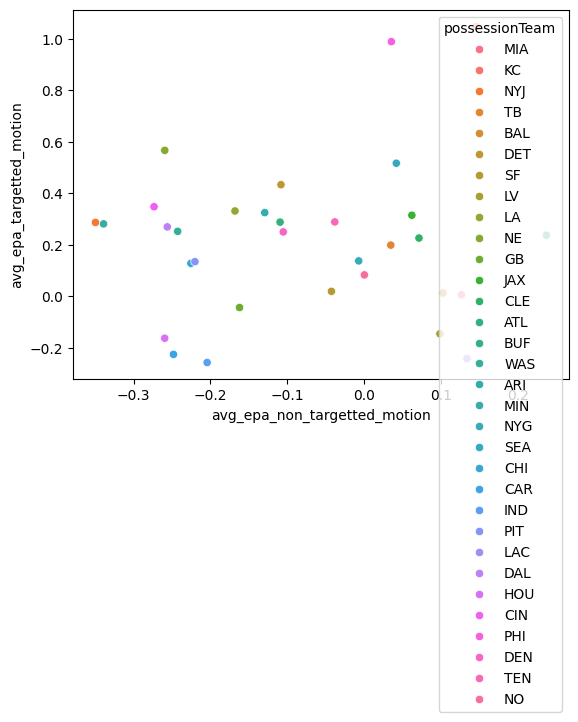

In [10]:
sns.scatterplot(data=plays_in_motion, x="avg_epa_non_targetted_motion", y="avg_epa_targetted_motion", hue="possessionTeam")

In [13]:
data.plays_df.collect().head()

shape: (5, 81)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ pla ┆ qua ┆ dow ┆ yar ┆ pos ┆ def ┆ yar ┆ yar ┆ gam ┆ pre ┆ pre ┆ pla ┆ abs ┆ pre ┆ pre ┆ exp ┆ off ┆ rec ┆ pla ┆ pas ┆ pas ┆ tar ┆ tar ┆ pla ┆ dro ┆ dro ┆ pas ┆ tim ┆ tim ┆ tim ┆ pas ┆ unb ┆ qbS ┆ qbK ┆ qbS ┆ rus ┆ pen ┆ pre ┆ yar ┆ hom ┆ vis ┆ exp ┆ isD ┆ pff ┆ pff ┆ pff ┆ pff ┆ pff ┆ sea ┆ wee ┆ gam ┆ gam ┆ hom ┆ vis ┆ hom ┆ vis ┆ dis ┆ pla ┆ pre ┆ pre ┆ pre ┆ pre ┆ pos ┆ def ┆ def ┆ sco ┆ pos ┆ pos ┆ pos ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ pla ┆ def ┆ def ┆ def │
│ eId ┆ yId ┆ yDe ┆ rte ┆ n   ┆ dsT ┆ ses ┆ ens ┆ dli ┆ dli ┆ eCl ┆ Sna ┆ Sna ┆ yNu ┆ olu ┆ Sna ┆ Sna ┆ ect ┆ ens ┆ eiv ┆ yCl ┆ sRe ┆ sLe ┆ get ┆ get ┆ yAc ┆ pba ┆ pba ┆ sLo ┆ eTo ┆ eIn ┆ eTo ┆ sTi ┆ loc ┆ pik ┆ nee ┆ nea ┆ hLo ┆ alt ┆ Pen ┆ dsG ┆ eTe ┆ ito ┆ ect ┆ rop ┆ _ru ┆ _ru ┆ _ru ┆ _pa ┆ _ma ┆ son ┆ k   ┆ eDa ┆ eTi ┆ eTe ┆ ito ┆ eFi ┆ ito ┆ tan ┆ yTy ┆ Sna ┆ Sna ┆ Sna ┆ Sna ┆ ses ┆ ens ┆ ens ┆ reD ┆ ses ┆ ses ┆ ses ┆ yer ┆ yer ┆ yHa ┆ yHa ┆ yHa ┆ yha ┆ yHa ┆ ens ┆ ens ┆ ens │
│ --- ┆ --- ┆ scr ┆ r   ┆ --- ┆ oGo ┆ sio ┆ ive ┆ neS ┆ neN ┆ ock ┆ pHo ┆ pVi ┆ lli ┆ teY ┆ pHo ┆ pVi ┆ edP ┆ eFo ┆ erA ┆ ock ┆ sul ┆ ngt ┆ X   ┆ Y   ┆ tio ┆ ckT ┆ ckD ┆ cat ┆ Thr ┆ Tac ┆ Sac ┆ ppe ┆ ked ┆ e   ┆ l   ┆ k   ┆ cat ┆ yYa ┆ alt ┆ ain ┆ amW ┆ rTe ┆ edP ┆ bac ┆ nCo ┆ nCo ┆ nPa ┆ ssC ┆ nZo ┆ --- ┆ --- ┆ te  ┆ meE ┆ amA ┆ rTe ┆ nal ┆ rFi ┆ ceT ┆ pe  ┆ pPo ┆ pDe ┆ pPo ┆ pDe ┆ sio ┆ ive ┆ ive ┆ iff ┆ sio ┆ sio ┆ sio ┆ Mot ┆ InM ┆ dPl ┆ dPl ┆ dPl ┆ dPl ┆ dMo ┆ ive ┆ ive ┆ ive │
│ i64 ┆ i64 ┆ ipt ┆ --- ┆ i64 ┆ --- ┆ nTe ┆ Tea ┆ ide ┆ umb ┆ --- ┆ meS ┆ sit ┆ fie ┆ ard ┆ meT ┆ sit ┆ oin ┆ rma ┆ lig ┆ AtS ┆ t   ┆ h   ┆ --- ┆ --- ┆ n   ┆ ype ┆ ist ┆ ion ┆ ow  ┆ kle ┆ k   ┆ dAt ┆ Pre ┆ --- ┆ --- ┆ --- ┆ ion ┆ rds ┆ yYa ┆ ed  ┆ inP ┆ amW ┆ oin ┆ k   ┆ nce ┆ nce ┆ ssO ┆ ove ┆ ne  ┆ i64 ┆ i64 ┆ --- ┆ ast ┆ bbr ┆ amA ┆ Sco ┆ nal ┆ oEn ┆ --- ┆ sse ┆ fen ┆ sse ┆ fen ┆ nTe ┆ Tea ┆ Tea ┆ ere ┆ nTe ┆ nTe ┆ nTe ┆ ion ┆ oti ┆ aye ┆ aye ┆ aye ┆ aye ┆ tio ┆ Tea ┆ Tea ┆ Tea │
│     ┆     ┆ ion ┆ i64 ┆     ┆ i64 ┆ am  ┆ m   ┆ --- ┆ er  ┆ str ┆ cor ┆ orS ┆ dBy ┆ lin ┆ eam ┆ orT ┆ ts  ┆ tio ┆ nme ┆ nap ┆ --- ┆ --- ┆ str ┆ str ┆ --- ┆ --- ┆ anc ┆ Typ ┆ --- ┆ Box ┆ --- ┆ Lin ┆ ssu ┆ str ┆ i64 ┆ str ┆ Typ ┆ --- ┆ rds ┆ --- ┆ rob ┆ inP ┆ tsA ┆ --- ┆ ptP ┆ ptS ┆ pti ┆ rag ┆ --- ┆     ┆     ┆ str ┆ ern ┆ --- ┆ bbr ┆ re  ┆ Sco ┆ dzo ┆ str ┆ ssi ┆ siv ┆ ssi ┆ siv ┆ amW ┆ mWP ┆ mEx ┆ nce ┆ amN ┆ amN ┆ amN ┆ Was ┆ onA ┆ rsI ┆ rsM ┆ rsS ┆ rsM ┆ n   ┆ mNu ┆ mNu ┆ mNu │
│     ┆     ┆ --- ┆     ┆     ┆     ┆ --- ┆ --- ┆ str ┆ --- ┆     ┆ e   ┆ cor ┆ Pen ┆ eNu ┆ Win ┆ eam ┆ --- ┆ n   ┆ nt  ┆ --- ┆ str ┆ str ┆     ┆     ┆ boo ┆ str ┆ e   ┆ e   ┆ str ┆ --- ┆ str ┆ e   ┆ re  ┆     ┆     ┆     ┆ e   ┆ str ┆ Gai ┆ i64 ┆ abi ┆ rob ┆ dde ┆ boo ┆ rim ┆ eco ┆ on  ┆ e   ┆ str ┆     ┆     ┆     ┆ --- ┆ str ┆ --- ┆ --- ┆ re  ┆ ne  ┆     ┆ onT ┆ eTe ┆ onT ┆ eTe ┆ PAd ┆ Add ┆ pec ┆ --- ┆ umP ┆ umP ┆ umP ┆ Tar ┆ tSn ┆ nMo ┆ oti ┆ hif ┆ oti ┆ --- ┆ mPl ┆ mPl ┆ mPl │
│     ┆     ┆ str ┆     ┆     ┆     ┆ str ┆ str ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆ alt ┆ mbe ┆ Pro ┆ Win ┆ f64 ┆ --- ┆ --- ┆ i64 ┆     ┆     ┆     ┆     ┆ l   ┆     ┆ --- ┆ --- ┆     ┆ str ┆     ┆ --- ┆ --- ┆     ┆     ┆     ┆ --- ┆     ┆ ned ┆     ┆ lit ┆ ili ┆ d   ┆ l   ┆ ary ┆ nda ┆ --- ┆ --- ┆     ┆     ┆     ┆     ┆ str ┆     ┆ str ┆ i64 ┆ --- ┆ --- ┆     ┆ eam ┆ amS ┆ eam ┆ amW ┆ ded ┆ ed  ┆ ted ┆ i64 ┆ lay ┆ lay ┆ lay ┆ get ┆ apW ┆ tio ┆ onS ┆ tSi ┆ onO ┆ i32 ┆ aye ┆ aye ┆ aye │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ --- ┆ y

In [18]:
data.plays_df.filter(pl.col("playType") == "pass").filter(pl.col("playHadMotion") == 1).group_by("possessionTeam").agg(count=pl.count("playId"), 
                                                                                  avg_players_in_motion=pl.mean("possessionTeamNumPlayersMotionSinceLineset"),
                                                                                  targetted_motion=pl.mean("playerMotionWasTargetted")).collect().sort("avg_players_in_motion", descending=True)

shape: (32, 4)
┌────────────────┬───────┬───────────────────────┬──────────────────┐
│ possessionTeam ┆ count ┆ avg_players_in_motion ┆ targetted_motion │
│ ---            ┆ ---   ┆ ---                   ┆ ---              │
│ str            ┆ u32   ┆ f64                   ┆ f64              │
╞════════════════╪═══════╪═══════════════════════╪══════════════════╡
│ DET            ┆ 185   ┆ 1.102703              ┆ 0.259459         │
│ MIN            ┆ 154   ┆ 1.071429              ┆ 0.220779         │
│ ATL            ┆ 160   ┆ 1.05                  ┆ 0.225            │
│ NYG            ┆ 150   ┆ 1.0                   ┆ 0.246667         │
│ CLE            ┆ 163   ┆ 0.98773               ┆ 0.202454         │
│ NO             ┆ 69    ┆ 0.985507              ┆ 0.246377         │
│ BUF            ┆ 158   ┆ 0.981013              ┆ 0.303797         │
│ TB             ┆ 200   ┆ 0.96                  ┆ 0.22             │
│ IND            ┆ 144   ┆ 0.9375                ┆ 0.208333         │
│ MIA            ┆ 269   ┆ 0.929368              ┆ 0.163569         │
│ CAR            ┆ 145   ┆ 0.924138              ┆ 0.331034         │
│ PIT            ┆ 136   ┆ 0.897059              ┆ 0.227941         │
│ CIN            ┆ 123   ┆ 0.894309              ┆ 0.219512         │
│ PHI            ┆ 117   ┆ 0.880342              ┆ 0.188034         │
│ BAL            ┆ 197   ┆ 0.862944              ┆ 0.137056         │
│ NYJ            ┆ 232   ┆ 0.862069              ┆ 0.189655         │
│ WAS            ┆ 156   ┆ 0.858974              ┆ 0.230769         │
│ JAX            ┆ 163   ┆ 0.846626              ┆ 0.251534         │
│ TEN            ┆ 92    ┆ 0.836957              ┆ 0.206522         │
│ HOU            ┆ 125   ┆ 0.832                 ┆ 0.24             │
│ DAL            ┆ 125   ┆ 0.832                 ┆ 0.264            │
│ NE             ┆ 169   ┆ 0.828402              ┆ 0.248521         │
│ LAC            ┆ 130   ┆ 0.807692              ┆ 0.207692         │
│ SEA            ┆ 149   ┆ 0.805369              ┆ 0.261745         │
│ CHI            ┆ 146   ┆ 0.794521              ┆ 0.178082         │
│ LV             ┆ 171   ┆ 0.77193               ┆ 0.216374         │
│ DEN            ┆ 115   ┆ 0.721739              ┆ 0.191304         │
│ KC             ┆ 256   ┆ 0.699219              ┆ 0.238281         │
│ GB             ┆ 167   ┆ 0.688623              ┆ 0.203593         │
│ SF             ┆ 179   ┆ 0.648045              ┆ 0.217877         │
│ ARI            ┆ 154   ┆ 0.636364              ┆ 0.246753         │
│ LA             ┆ 169   ┆ 0.615385              ┆ 0.236686         │
└────────────────┴───────┴───────────────────────┴──────────────────┘

In [22]:
data.raw_player_plays.group_by(["motionSinceLineset", "shiftSinceLineset"]).agg(count=pl.count("playId")).collect()

shape: (6, 3)
┌────────────────────┬───────────────────┬────────┐
│ motionSinceLineset ┆ shiftSinceLineset ┆ count  │
│ ---                ┆ ---               ┆ ---    │
│ str                ┆ str               ┆ u32    │
╞════════════════════╪═══════════════════╪════════╡
│ FALSE              ┆ FALSE             ┆ 84416  │
│ NA                 ┆ FALSE             ┆ 82829  │
│ NA                 ┆ NA                ┆ 178549 │
│ TRUE               ┆ FALSE             ┆ 5176   │
│ NA                 ┆ TRUE              ┆ 3111   │
│ TRUE               ┆ TRUE              ┆ 646    │
└────────────────────┴───────────────────┴────────┘

In [23]:
data.raw_player_plays.filter((pl.col("shiftSinceLineset") == "TRUE") & (pl.col("motionSinceLineset") == "NA")).collect().head()

shape: (5, 50)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ gam ┆ pla ┆ nfl ┆ tea ┆ had ┆ rus ┆ had ┆ pas ┆ sac ┆ had ┆ rec ┆ was ┆ yar ┆ fum ┆ fum ┆ fum ┆ ass ┆ for ┆ hal ┆ pas ┆ qua ┆ sac ┆ saf ┆ sol ┆ tac ┆ tac ┆ tac ┆ had ┆ int ┆ fum ┆ fum ┆ pen ┆ pen ┆ was ┆ cau ┆ tim ┆ get ┆ inM ┆ shi ┆ mot ┆ was ┆ rou ┆ blo ┆ blo ┆ blo ┆ pre ┆ tim ┆ pff ┆ pff ┆ pff │
│ eId ┆ yId ┆ Id  ┆ mAb ┆ Rus ┆ hin ┆ Dro ┆ sin ┆ kYa ┆ Pas ┆ eiv ┆ Tar ┆ dag ┆ ble ┆ ble ┆ ble ┆ ist ┆ ced ┆ fSa ┆ sDe ┆ rte ┆ kYa ┆ ety ┆ oTa ┆ kle ┆ kle ┆ kle ┆ Int ┆ erc ┆ ble ┆ ble ┆ alt ┆ alt ┆ Ini ┆ sed ┆ eTo ┆ Off ┆ oti ┆ ftS ┆ ion ┆ Run ┆ teR ┆ cke ┆ cke ┆ cke ┆ ssu ┆ eTo ┆ _de ┆ _pr ┆ _se │
│ --- ┆ --- ┆ --- ┆ br  ┆ hAt ┆ gYa ┆ pba ┆ gYa ┆ rds ┆ sRe ┆ ing ┆ get ┆ eGa ┆ s   ┆ Los ┆ Out ┆ edT ┆ Fum ┆ ckY ┆ fen ┆ rba ┆ rds ┆ AsD ┆ ckl ┆ Ass ┆ For ┆ For ┆ erc ┆ ept ┆ Rec ┆ Rec ┆ yYa ┆ yNa ┆ tia ┆ Pre ┆ Pre ┆ Tim ┆ onA ┆ inc ┆ Sin ┆ nin ┆ an  ┆ dPl ┆ dPl ┆ dPl ┆ reA ┆ Pre ┆ fen ┆ ima ┆ con │
│ i64 ┆ i64 ┆ i64 ┆ --- ┆ tem ┆ rds ┆ ck  ┆ rds ┆ AsO ┆ cep ┆ Yar ┆ ted ┆ ine ┆ --- ┆ t   ┆ OfB ┆ ack ┆ ble ┆ ard ┆ sed ┆ ckH ┆ AsD ┆ efe ┆ e   ┆ ist ┆ ALo ┆ ALo ┆ ept ┆ ion ┆ ove ┆ ove ┆ rds ┆ mes ┆ lPa ┆ ssu ┆ ssu ┆ eAs ┆ tBa ┆ eLi ┆ ceL ┆ gRo ┆ --- ┆ aye ┆ aye ┆ aye ┆ llo ┆ ssu ┆ siv ┆ ryD ┆ dar │
│     ┆     ┆     ┆ str ┆ pt  ┆ --- ┆ --- ┆ --- ┆ ffe ┆ tio ┆ ds  ┆ Rec ┆ dAf ┆ i64 ┆ --- ┆ oun ┆ le  ┆ AsD ┆ sAs ┆ --- ┆ it  ┆ efe ┆ nse ┆ --- ┆ --- ┆ ss  ┆ ssY ┆ ion ┆ Yar ┆ rie ┆ ryY ┆ --- ┆ --- ┆ ssR ┆ re  ┆ reA ┆ Pas ┆ llS ┆ nes ┆ ine ┆ ute ┆ str ┆ rNF ┆ rNF ┆ rNF ┆ wed ┆ reA ┆ eCo ┆ efe ┆ yDe │
│     ┆     ┆     ┆     ┆ --- ┆ i64 ┆ i64 ┆ i64 ┆ nse ┆ n   ┆ --- ┆ eiv ┆ ter ┆     ┆ i64 ┆ ds  ┆ --- ┆ efe ┆ Def ┆ i64 ┆ --- ┆ nse ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ ard ┆ --- ┆ ds  ┆ s   ┆ ard ┆ i64 ┆ str ┆ ush ┆ --- ┆ sPa ┆ sRu ┆ nap ┆ et  ┆ set ┆ --- ┆     ┆ LId ┆ LId ┆ LId ┆ AsB ┆ llo ┆ ver ┆ nsi ┆ fen │
│     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ --- ┆ --- ┆ i64 ┆ er  ┆ The ┆     ┆     ┆ --- ┆ i64 ┆ nse ┆ ens ┆     ┆ i64 ┆ --- ┆ i64 ┆     ┆     ┆ i64 ┆ age ┆ i64 ┆ --- ┆ --- ┆ s   ┆     ┆     ┆ er  ┆ boo ┆ ssR ┆ she ┆ --- ┆ --- ┆ --- ┆ str ┆     ┆ 1   ┆ 2   ┆ 3   ┆ loc ┆ wed ┆ age ┆ veC ┆ siv │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ i64 ┆     ┆ --- ┆ Cat ┆     ┆     ┆ i64 ┆     ┆ --- ┆ e   ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆     ┆ i64 ┆ i64 ┆ --- ┆     ┆     ┆ --- ┆ l   ┆ ush ┆ r   ┆ str ┆ str ┆ str ┆     ┆     ┆ --- ┆ --- ┆ --- ┆ ker ┆ AsB ┆ Ass ┆ ove ┆ eCo │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆ ch  ┆     ┆     ┆     ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆ str ┆     ┆ er  ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆ str ┆ --- ┆ loc ┆ ign ┆ rag ┆ ver │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ker ┆ men ┆ eMa ┆ age │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ …   ┆ …   ┆ …   │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ --- ┆ --- ┆ --- │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆    

<Axes: xlabel='timeToThrow'>

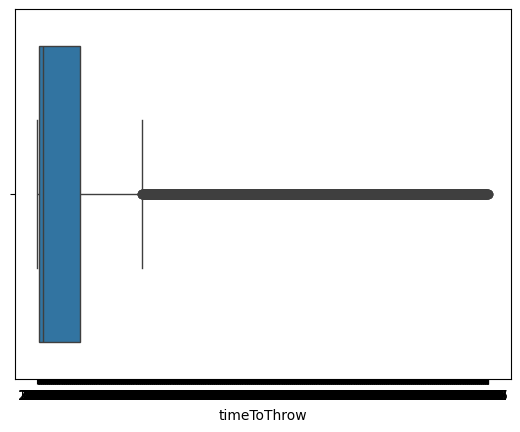

In [8]:
sns.boxplot(data=data.plays_df.collect(), x="timeToThrow")

In [11]:
data.plays_df.filter(pl.col("timeToThrow") != "NA").select(time_to_throw_avg=pl.col("timeToThrow").cast(pl.Float64).median()).collect()

shape: (1, 1)
┌───────────────────┐
│ time_to_throw_avg │
│ ---               │
│ f64               │
╞═══════════════════╡
│ 2.587             │
└───────────────────┘